<a href="https://colab.research.google.com/github/manuelec/Simple-Python-Chatbot/blob/master/%5BProject_Stamina%5D_StravaPerfLib_10Feb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Context: Programming, Python]
[Program: build in Google Colab a program to extract cycling performance data via Strava API, make data manipulation preparation then feed the data along with a well structured prompt to get processed by Gemini LLM via API]
[Objective: create an AI cycling coach that analyses data, evaluate performance overtime and provide suggestions on next steps and training plan]
[Ask: help the software developer building code, find solutions and debug issues. Ensure the proposed python code complies with Strava, Gemini API and any other future data integration like FitBit or other fitness trackers. The solutions you propose must always be ready to be integrated into the main program workflow you are provided. Provide always the full code and avoid truncating the code or providing misleading examples. Make sure to find ground truth online before replying]

In [1]:
!pip install google-genai
!pip install -U -q "google-generativeai>=0.8.2"
!pip install stravalib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.0/125.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 14.0 MB/s eta 0:00:00




---



# STAMINA

## [1] Import Libs / Authtencication Strava, Gemini, other APIs

In [2]:
#@title Import Libs
import datetime
import warnings
import contextlib
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=ImportWarning)
import matplotlib.pyplot as plt
import os
import datetime
from datetime import timedelta
import google.generativeai as genai
from google.genai import types
from stravalib.client import Client
from stravalib.exc import RateLimitExceeded
from stravalib.exc import AccessUnauthorized
import json
import pandas as pd
from datetime import timedelta
import time
import numpy as np
import math
from google.colab import userdata
from IPython.display import display, Markdown
from google.generativeai import upload_file

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:502: UserWarning: <built-in function any> is not a Python type (it may be an instance of an object), Pydantic will allow any object with no validation since we cannot even enforce that the input is an instance of the given type. To get rid of this error wrap the type with `pydantic.SkipValidation`.
  warn(
















Authentication Flow

- Complete Authentication Process
- First, run the initial_authentication() function
- Visit the authorization URL in your browser
- Authorize the application
- Copy the full URL and paste it here
- The function will return valid access like "Successfully authenticated for athlete: Manuele Caddeo"


In [3]:
#@title Strava Credentials
# Strava credentials
STRAVA_CLIENT_ID = "143458" #permanent credentials from your Strava API application
STRAVA_CLIENT_SECRET = "4e6a673a30836aed9f1d59e44853a9919ccb45be" # permanent credentials from your Strava API application
STRAVA_REFRESH_TOKEN = "b24edd3518932128ee79401a1af94ffa7ef6abe5"
REDIRECT_URI = "http://localhost"  # For testing

  and should_run_async(code)



In [4]:
#@title Gemini GenAi setup
# --- 1. API Key Configuration ---
try:
    # Use Colab secrets for API key management
    os.environ["GOOGLE_API_KEY"] = userdata.get("GOOGLE_API_KEY")
    genai.configure(api_key=os.environ["GOOGLE_API_KEY"])
except ImportError:
    print("Warning: Could not import google.colab.userdata. "
          "Make sure your API key is stored in the GOOGLE_API_KEY environment variable.")
    # Attempt to use the API key from the environment variable
    if "GOOGLE_API_KEY" in os.environ:
        genai.configure(api_key=os.environ["GOOGLE_API_KEY"])
    else:
        raise ValueError("GOOGLE_API_KEY environment variable not set.")

# --- 2. Model and Generation Configuration ---
generation_config = {
  "temperature": 0.1,
  "top_p": 0.95,
  "top_k": 40,
  "max_output_tokens": 8192,
  "response_mime_type": "text/plain",
}

system_instruction = f"""
Talk to the athlete in first person, like you were a master cycling coach talking with your athlete. Use the Athelte name to talk with him. Be informal and scientific.
As an expert cycling coach, analyze this athlete's latest ride performance and find relationships with performance trends\n
over the previous 7 days of latest cycling training session, then previous 30 days vs to last week and previous 30 days to the last 30 days.\n
The latest ride shows the absolute metrics, while last 7 days, previous 30 days and preivous 30 days (30 to 60 days ago) are averages.\n
Having on hands past averages (most recent and back in time) will help you to evaluate how the athlete is trending considering its values.\n
Take in consideration that some trainings may be 'indoor training' on turbo trainer exexuted via Zwift or similar virtual cycling applications; these type of training are short (max 1.5h) and very intense (high power, high HR).\n
You are also provided with Power and HR zones, very useful insights to assess the training type, the effort of the last training and the workload of previous periods.\n
Another very important metrics to analyze are TSS, CTR and ACWR. You are provided of both chart and values, ensure to analyze there before providing your response.\n
Remember to be analytical, use the data provided in the prompt to make your deductions. Do not add data that is not provided, stick to the prompt details.\n
The user you are interacting with (the Athlete) expects to get a short summary of your evaluation with explicit datapoints sustaining your assessement.\n
Adapt your suggestion depending on the type of Athlete (low, medium or highly trained): by looking at the historical training data (quantitaive and qualitative) you can assess if the user is an entry level amateur, an advanced amateur or a pro cyclist.\n
A low trained enthusiast cyclist train only 2-3 days a week, with 5 to 10 hours. A medium cyclist ready to do Granfondo train between 10 to 15 hours per week. A highly trained cyclist able to win a Granfondo train between 15 to 20 hours per week.\n
With the data you are provided, make your own assessement also by looking at their power in absolute and relative terms. An Athlete with 350 FTP and 65 Kg is a very strong rider (5,3 w/kg), the relationship between power and weight is very important in cycling, remember this.\n
Whatever is the follow-up question, if any to the first response, make sure to adapt your suggestion and tone depending on the single characteristic of the Athelte (the cyclist).\n
If the cyclist ask about next training suggestion or recovery, make sure to adapt your suggestion as well: for a highly trained cyclist with string metrics, it's normal to observe high fatigue and stress, while for a low-trained cyclist is not to avoid injuries.\n
Remember, a strong highly trained cyclist can train up to 20 hours per week, with many different types of training, from endurance to highly structured training.\n
You are also provided with training plans from top pro cycling club you can use to learn from the best in class and make suggestion basing on these trainings.\n
"""

# Create the model instance ONCE, and use the correct model name
model = genai.GenerativeModel(
    model_name="gemini-2.0-flash",  # gemini-1.5-flash-8b, gemini-1.5-pro
    generation_config=generation_config,
    system_instruction=system_instruction)

def upload_to_gemini(path, mime_type=None):
  """Uploads the given file to Gemini.

  See https://ai.google.dev/gemini-api/docs/prompting_with_media
  """
  file = genai.upload_file(path, mime_type=mime_type)
  print(f"Uploaded file '{file.display_name}' as: {file.uri}")
  return file

In [5]:
#@title Strava Auth / Tokens with Refresh

################################################################################
def get_auth_url():
    client = Client()
    auth_url = client.authorization_url(
        client_id=STRAVA_CLIENT_ID,
        redirect_uri='http://localhost',  # This is fine as is
        scope=['read_all', 'profile:read_all', 'activity:read_all']
    )
    return auth_url

def extract_code_from_url(redirect_url):
    # Extract the code parameter from the URL
    code = redirect_url.split('code=')[1].split('&')[0]
    return code

def store_tokens(access_token, refresh_token):
    tokens = {
        'access_token': access_token,
        'refresh_token': refresh_token
    }
    with open('strava_config.json', 'w') as f:
        json.dump(tokens, f)
        print("Tokens successfully stored")

def get_stored_tokens():
    try:
        with open('strava_config.json', 'r') as f:
            tokens = json.load(f)
        return tokens['access_token'], tokens['refresh_token']
    except FileNotFoundError:
        return None, None
################################################################################

from stravalib.exc import AccessUnauthorized

def refresh_access_token(client, refresh_token):
    try:
        response = client.refresh_access_token(
            client_id=STRAVA_CLIENT_ID,
            client_secret=STRAVA_CLIENT_SECRET,
            refresh_token=refresh_token
        )
        new_access_token = response['access_token']
        new_refresh_token = response['refresh_token']
        store_tokens(new_access_token, new_refresh_token)
        return new_access_token
    except Exception as e:
        print(f"Error refreshing token: {e}")
        return None

def authenticate_strava():
    try:
        access_token, refresh_token = get_stored_tokens()

        if not access_token:
            # If no stored tokens, run authentication flow
            auth_url = get_auth_url()
            print(f"Visit this URL to authorize: {auth_url}")
            redirect_url = input("Paste the full redirect URL here: ")
            code = extract_code_from_url(redirect_url)

            client = Client()
            token_response = client.exchange_code_for_token(
                client_id=STRAVA_CLIENT_ID,
                client_secret=STRAVA_CLIENT_SECRET,
                code=code
            )

            access_token = token_response['access_token']
            refresh_token = token_response['refresh_token']
            store_tokens(access_token, refresh_token)

        # Test authentication
        client = Client(access_token)
        try:
            athlete = client.get_athlete()
            print(f"Successfully authenticated for athlete: {athlete.firstname} {athlete.lastname}")
        except AccessUnauthorized:
            print("Access token expired, attempting to refresh...")
            access_token = refresh_access_token(client, refresh_token)
            if access_token:
                client = Client(access_token)
                athlete = client.get_athlete()
                print(f"Successfully re-authenticated for athlete: {athlete.firstname} {athlete.lastname}")
            else:
                print("Failed to refresh token. Please re-authorize the application.")
                return None

        return access_token

    except Exception as e:
        print(f"Authentication error: {e}")
        return None


In [6]:
#@title Authenticate athlete
access_token = authenticate_strava()
client = Client(access_token=access_token)
athlete = client.get_athlete()  # Uses /athlete endpoint
AthleteName = athlete.firstname + " " + athlete.lastname

ERROR:root:Please make sure your STRAVA_CLIENT_ID is set in your environment.


Visit this URL to authorize: https://www.strava.com/oauth/authorize?client_id=143458&redirect_uri=http%3A%2F%2Flocalhost&approval_prompt=auto&scope=read_all%2Cprofile%3Aread_all%2Cactivity%3Aread_all&response_type=code
Paste the full redirect URL here: http://localhost/?state=&code=3bf4cf1ff25a3eeb9ed624cded3736e9485c2e3e&scope=read,activity:read_all,profile:read_all,read_all


ERROR:root:Please make sure your STRAVA_CLIENT_ID is set in your environment.
ERROR:root:Please make sure your STRAVA_CLIENT_ID is set in your environment.


Tokens successfully stored


ERROR:root:Please make sure your STRAVA_CLIENT_ID is set in your environment.


Successfully authenticated for athlete: Manuele Caddeo


## [Strava Functions] Power and HR Zones Calc

In [7]:
#@title Step 1: Fetch and parse zones function >> to get_cycling_data
def fetch_and_parse_zones(client, activity_id, total_moving_time):
    try:
        full_activity = client.get_activity(activity_id, include_all_efforts=False)
        activity_zones = getattr(full_activity, "zones", [])

        if not activity_zones:
            return {}, {}

        power_zone_times = {}
        power_zone_percent = {}
        hr_zone_times = {}
        hr_zone_percent = {}

        for zone_info in activity_zones:
            ztype = getattr(zone_info, "type", "")
            distribution = getattr(zone_info, "distribution_buckets", [])
            for idx, bucket in enumerate(distribution):
                time_in_zone = getattr(bucket, "time", 0) or 0
                pct_in_zone = (time_in_zone / total_moving_time) * 100.0 if total_moving_time > 0 else 0

                if ztype == "power":
                    power_zone_times[f"power_zone_time_{idx}"] = time_in_zone
                    power_zone_percent[f"power_zone_pct_{idx}"] = pct_in_zone
                elif ztype == "heartrate":
                    hr_zone_times[f"hr_zone_time_{idx}"] = time_in_zone
                    hr_zone_percent[f"hr_zone_pct_{idx}"] = pct_in_zone

        return {**power_zone_times, **hr_zone_times}, {**power_zone_percent, **hr_zone_percent}

    except Exception as e:
        st.error(f"Error fetching or parsing zones for activity {activity_id}: {e}")
        return {}, {}


**Default Power Zone Ranges (Z1–Z7)**

**Strava typically uses 7 power zones for cycling, which are defined as percentages of FTP:**

| Zone | Name | % of FTP | Example Range (FTP = 300W) |
|---|---|---|---|
| Z1 | Active Recovery | <55% | 0–165W |
| Z2 | Endurance | 55–75% | 166–225W |
| Z3 | Tempo | 76–90% | 226–270W |
| Z4 | Threshold | 91–105% | 271–315W |
| Z5 | VO2 Max | 106–120% | 316–360W |
| Z6 | Anaerobic Capacity | 121–150% | 361–450W |
| Z7 | Neuromuscular Power | >150% | >450W |

These ranges can be customized by users in their Strava settings, so you may need to retrieve the athlete's FTP and calculate the corresponding wattage boundaries dynamically.

If Strava uses fixed wattage buckets for API call for raw zones, we need to explicitly define them in our code.

Define Raw Power Zone Ranges
Assume the following ranges for raw power zones based on typical configurations:

| Raw Zone | Wattage Range (W) |
|---|---|
| Zone 0 | 0–0 |
| Zone 1 | 0–50 |
| Zone 2 | 50–100 |
| Zone 3 | 100–150 |
| Zone 4 | 150–200 |
| Zone 5 | 200–250 |
| Zone 6 | 250–300 |
| Zone 7 | 300–350 |
| Zone 8 | 350–400 |
| Zone 9 | 400–450 |
| Zone 10 | >500 |

In [8]:
#@title Step 2: Retrieve Athlete's FTP
ftp_athlete = getattr(athlete, 'ftp', None)  # Retrieve FTP if available

In [9]:
#@title Step 3: Define Grouped Power Zones Based on FTP
# Using the ranges in Section 1, calculate wattage boundaries for each zone dynamically based on ftp_athlete:

# Define grouped power zones as percentages of FTP
power_zones = [
    {"zone": "Z1", "name": "Active Recovery", "min": 0.0,  "max": 0.54},
    {"zone": "Z2", "name": "Endurance",       "min": 0.541, "max": 0.75},
    {"zone": "Z3", "name": "Tempo",          "min": 0.751, "max": 0.90},
    {"zone": "Z4", "name": "Threshold",      "min": 0.901, "max": 1.05},
    {"zone": "Z5", "name": "VO2 Max",        "min": 1.051, "max": 1.20},
    {"zone": "Z6", "name": "Anaerobic",      "min": 1.201, "max": 1.50},
    {"zone": "Z7", "name": "Neuromuscular",  "min": 1.501, "max": float("inf")},
]

# Convert the percentage-based boundaries into actual wattage ranges
for zone in power_zones:
    zone["watt_min"] = ftp_athlete * zone["min"]
    zone["watt_max"] = ftp_athlete * zone["max"]

In [10]:
#@title Step 4: Aggregate Raw Power Zones into Grouped Zones
def aggregate_power_zones(series, ftp_athlete, power_zones):
    """
    Aggregates raw power zones into FTP-based zones.

    Args:
    series: A pandas Series containing power zone time data
    ftp_athlete: The athlete's Functional Threshold Power
    power_zones: A list of dictionaries defining the FTP-based power zones

    Returns:
    A dictionary of aggregated time spent in each FTP-based zone
    """

    # 1) Initialize aggregator for each zone
    aggregated_zones = {
        z["zone"]: {"name": z["name"], "time_sec": 0.0}
        for z in power_zones
    }

    # 2) Define raw wattage buckets for 11 zones as default output from Strava API
    raw_zone_ranges = raw_zone_ranges = [
        (0, 0),      # Zone 0
        (1, 50),     # Zone 1
        (51, 100),   # Zone 2
        (101, 150),  # Zone 3
        (151, 200),  # Zone 4
        (201, 250),  # Zone 5
        (251, 300),  # Zone 6
        (301, 350),  # Zone 7
        (351, 400),  # Zone 8
        (401, 450),  # Zone 9
        (451, float("inf"))  # Zone 10
    ]

    # 3) Go through each raw zone
    for i, (raw_min, raw_max) in enumerate(raw_zone_ranges):
        time_col = f"power_zone_time_{i}"
        if time_col in series and pd.notna(series[time_col]):
            time_in_zone_sec = series[time_col]

            if not math.isfinite(raw_max):
                raw_max = 99999.0

            raw_width = raw_max - raw_min
            if raw_width <= 0:
                raw_width = 1  # Avoid division by zero for the 0-0W zone

            for pz in power_zones:
                g_min = pz["watt_min"]
                g_max = pz["watt_max"]

                # Special case for the 0-0W zone (raw zone 0)
                if i == 0:
                    if pz["zone"] == "Z1":
                        aggregated_zones[pz["zone"]]["time_sec"] += time_in_zone_sec
                        # only for debugging
                        # print(f"Adding {time_in_zone_sec:.1f} sec to Z1 (raw zone 0)")
                    continue

                # If there's an intersection
                if g_max > raw_min and g_min < raw_max:
                    overlap_min = max(g_min, raw_min)
                    overlap_max = min(g_max, raw_max)
                    if overlap_max > overlap_min:
                        overlap_fraction = (overlap_max - overlap_min) / raw_width
                        if overlap_fraction < 0.01:
                            continue
                        overlap_fraction = round(overlap_fraction, 4)
                        time_added = time_in_zone_sec * overlap_fraction
                        aggregated_zones[pz["zone"]]["time_sec"] += time_added
                        # only for debugging
                        # print(f"Adding {time_added:.1f} sec to {pz['zone']} (overlap fraction: {overlap_fraction:.2f})")

    total_sec = sum(z["time_sec"] for z in aggregated_zones.values())

    for zdata in aggregated_zones.values():
        zdata["time_min"] = zdata["time_sec"] / 60.0
        zdata["percentage"] = (zdata["time_sec"] / total_sec) * 100.0 if total_sec > 0 else 0.0

    return aggregated_zones

In [11]:
#@title Step 5: Format Grouped Power Zones (Z1, Z2, Z3..) for Output
# Use this function to format the aggregated zones into a readable format:
def format_grouped_power_zones(aggregated_zones):
    """
    Formats grouped power zones into a readable string, including watt ranges.

    Args:
        aggregated_zones: Dictionary with aggregated time and percentage for each grouped power zone.

    Returns:
        A multi-line string describing time spent in each grouped power zone.
    """
    lines = []
    for zone, data in aggregated_zones.items():
        # Ensure no NaN values are passed to formatting
        t_min = data.get("time_min", 0.0) or 0.0
        pct = data.get("percentage", 0.0) or 0.0

        # Find the corresponding power zone data
        zone_data = next((z for z in power_zones if z["zone"] == zone), None)
        if zone_data:
            watt_min = zone_data["watt_min"]
            watt_max = zone_data["watt_max"]

            # Format max power, using "+" for the highest zone
            max_power_str = f"{watt_max:.0f}+" if watt_max == float("inf") else f"{watt_max:.0f}"

            lines.append(f"  - {zone} ({data['name']} [{watt_min:.0f}-{max_power_str}W]): {t_min:.1f} min ({pct:.1f}%)")
    return "\n".join(lines)



In [12]:
#@title Step 6: Format Raw HR-Power Distributions
def format_zone_distribution(series, zone_time_prefix="power_zone_time_", zone_pct_prefix="power_zone_pct_", zone_type="Power"):
    """
    Returns a string describing the Athlete's time (in minutes) and percentages spent in each zone.

    Args:
      series: A pandas Series or dict-like object with columns like "power_zone_time_0", "power_zone_pct_0", etc.
      zone_time_prefix: Column prefix for zone time in seconds (e.g., "power_zone_time_").
      zone_pct_prefix: Column prefix for zone percentage (e.g., "power_zone_pct_").
      zone_type: String label for the distribution type, e.g., "Power" or "HR".

    Returns:
      A multi-line string describing zone usage. Example:
        "Power Zone Distribution:
         - Zone 0: 32.2 min (19.1%)
         - Zone 1: 7.8 min (4.6%)
         ..."
      or a brief message if no zone data is found.
    """
    lines = []
    max_zones = 11

    for i in range(max_zones):
        time_col = f"{zone_time_prefix}{i}"
        pct_col = f"{zone_pct_prefix}{i}"

        if time_col in series and not pd.isna(series[time_col]):
            time_in_minutes = series[time_col] / 60
            pct_in_zone = series[pct_col] if pct_col in series and not pd.isna(series[pct_col]) else 0.0
            lines.append(f"    - Zone {i}: {time_in_minutes:.1f} min ({pct_in_zone:.1f}%)")
        else:
            break

    if not lines:
        return f"No {zone_type} zone data"

    return f"{zone_type} Zone Distribution:\n" + "\n".join(lines)


## [Strava Functions] Compute Intensity and TSS metrics

In [13]:
#@title Step 1: Calculate IF, TSS (Allen's formula)

def calculate_intensity_factor(weighted_average_watts, ftp):
    return weighted_average_watts / ftp if ftp and ftp > 0 else None


def calculate_training_stress_score(intensity_factor, duration_hours):
    return 100 * intensity_factor**2 * duration_hours if intensity_factor else None

In [14]:
#@title Step 2: Calculate Chronic Training Load (CTL) and ACWR (Acute:Chronic Workload Ratio)

#### revised version
# Key improvements in this version:
# Added calculate_alpha function as per Murray (2017) for proper exponential weighting
# Implemented correct exponential weighting for both CTL and ACWR calculations
# Added 'form' metric (CTL - ATL) as suggested by Allen for race preparation
# Used consistent time windows (42 days) for chronic load calculations
# Applied proper exponential weighting using pandas' ewm with calculated alpha values
# Maintained the existing TSS distribution calculation for the last 30 days

def calculate_stress_metrics(df):
    # Sort the dataframe by date in ascending order
    df = df.sort_values('start_date', ascending=True).reset_index(drop=True)

    # Create a date range from the earliest to the latest activity
    date_range = pd.date_range(start=df['start_date'].min().date(), end=df['start_date'].max().date(), freq='D')

    # Create a new dataframe with all dates
    daily_df = pd.DataFrame({'date': date_range})
    daily_df['date'] = pd.to_datetime(daily_df['date']).dt.tz_localize('UTC')

    # Aggregate TSS for each day, including all activities
    daily_tss = df.groupby(df['start_date'].dt.date)['training_stress_score'].sum().reset_index()
    daily_tss.columns = ['date', 'daily_tss']
    daily_tss['date'] = pd.to_datetime(daily_tss['date']).dt.tz_localize('UTC')

    # Merge the daily TSS with the full date range
    daily_df = daily_df.merge(daily_tss, on='date', how='left')
    daily_df['daily_tss'] = daily_df['daily_tss'].fillna(0)  # Fill rest days with 0 TSS

    # Calculate alpha values for exponential weighting
    alpha_ctl = 2 / (42 + 1)
    alpha_atl = 2 / (7 + 1)

    # Calculate CTL and ATL using EWMA
    daily_df['CTL'] = daily_df['daily_tss'].ewm(alpha=alpha_ctl, adjust=False).mean()
    daily_df['ATL'] = daily_df['daily_tss'].ewm(alpha=alpha_atl, adjust=False).mean()

    # Calculate ACWR and form only after day 42
    daily_df.loc[daily_df.index < 42, ['CTL', 'ATL']] = None
    daily_df['ACWR'] = daily_df['ATL'] / daily_df['CTL']
    daily_df['form'] = daily_df['CTL'] - daily_df['ATL']

    # Merge the calculated metrics back to the original dataframe
    df['date'] = df['start_date'].dt.date
    df['date'] = pd.to_datetime(df['date']).dt.tz_localize('UTC')
    df = df.merge(daily_df[['date', 'CTL', 'ATL', 'ACWR', 'form']], on='date', how='left')

    # Calculate TSS distribution for the last 30 days
    last_30_days = daily_df.iloc[-30:]
    low_tss_days = sum(last_30_days['daily_tss'] < 50)
    medium_tss_days = sum((last_30_days['daily_tss'] >= 50) & (last_30_days['daily_tss'] <= 100))
    high_tss_days = sum(last_30_days['daily_tss'] > 100)

    return df, low_tss_days, medium_tss_days, high_tss_days


**CTL Analysis**

The CTL chart shows a clear progression from around 50 to over 100, which aligns with the expected behavior of chronic training load. The exponentially weighted moving average over 42 days correctly shows:
Initial values around 50-60 (November-December)
Steady increase through December-January
Current value around 110, indicating improved fitness


**ACWR Analysis**

The ACWR calculation shows several important characteristics that validate its implementation:
Values mostly fluctuate between 0.8 and 1.8, which is the expected range1
The ratio correctly spikes when acute load (7-day TSS) increases rapidly relative to chronic load
Recent trend showing stabilization around 1.2-1.3, which is within the optimal range3

**TSS and Relationship Verification**

Looking at the TSS chart and its relationship with CTL and ACWR:
TSS spikes (around 200-250) correspond to ACWR increases, confirming proper acute load calculation
CTL's smooth progression despite TSS variability confirms correct implementation of the exponential weighting1
The relationship between all three metrics shows expected patterns:
High TSS days lead to ACWR spikes
Consistent TSS leads to steady CTL increase
CTL responds more slowly to changes, as intended

**For CTL:**
We'll use an exponentially weighted moving average of the daily TSS over the past 42 days (6 weeks), as suggested in the article.

**For ACWR (Acute:Chronic Workload Ratio):**
We'll calculate the ratio of the average TSS over the past 7 days (acute load) to the average TSS over the past 28 days (chronic load).

**For TSS distribution:**
We'll modify the calculation to only consider the last 30 days.

[Scientific Paper](https://ssp3nc3r.github.io/post/2020-05-08-calculating-training-load-in-cycling/#:~:text=Chronic%20Training%20Load%20(CTL).&text=It%20is%20calculated%20as%20an,in%20the%20past%20three%20months.))

**Scientific Backing**
1. Banister's Impulse-Response model suggests that both training and recovery contribute to fitness and fatigue.
2. Williams et al. (2017) emphasize the importance of considering all training loads, including low-intensity activities, in ACWR calculations.
3. Lazarus et al. (2017) recommend using daily aggregated training loads for more accurate ACWR c

### Correlation matrix

- CTL and ACWR: Moderate positive correlation (r=0.42).
- CTL and Form: Moderate negative correlation (r=−0.44).
- ACWR and Form: Strong negative correlation (r=−0.99), which is expected since ACWR reflects acute load relative to chronic load, and Form measures recovery (CTL - ATL).

#### Training Stress Score (TSS):
- Strong positive correlation with Moving Time (r=0.93), as TSS is directly influenced by duration.
- Moderate positive correlation with ACWR (r=0.71) and negative correlation with Form (r=−0.72).

####  Intensity Factor and Weighted Average Watts:
- Perfect correlation (r=1.00) with each other, as they are directly related through FTP.



---



## [Strava Functions] Get activity metrics with API

In [15]:
#@title 1. [Get Func] cycling data function
################################################################################

def get_cycling_data(access_token, per_page=1,fetch_zones_for_recent_days=1):
    """
    Returns df with Strava metrics and computed timeframes last, 7D, 30D, 60D.
    """
    try:
        client = Client(access_token=access_token)
        activities = []
        today = datetime.datetime.utcnow()
        threshold_date = today - timedelta(days=fetch_zones_for_recent_days)
        athlete = client.get_athlete()  # Uses /athlete endpoint

        # Fetch activities with rate limit handling
        try:
            activity_batch = client.get_activities(
                before=None,
                after=None,
                limit=per_page
            )

            for activity in activity_batch:
                if activity.type in ["Ride", "VirtualRide"] and not getattr(activity, 'commute', False):
                    moving_time = int(activity.moving_time.seconds) if hasattr(activity.moving_time, 'seconds') else int(activity.moving_time)
                    elapsed_time = int(activity.elapsed_time.seconds) if hasattr(activity.elapsed_time, 'seconds') else int(activity.elapsed_time)

                    ### Fetch zones (new 6 Jan integration)
                    # Default empty zone data
                    zone_time_data = {}
                    zone_pct_data = {}

                    # Decide if we should fetch zones for this ride
                    if activity.start_date.replace(tzinfo=None) >= threshold_date:
                        # We want zone data for recent rides
                        zone_time_data, zone_pct_data = fetch_and_parse_zones(
                            client=client,
                            activity_id=activity.id,
                            total_moving_time=moving_time
                        )
                    # Debug print
                    # print(f"Zone time data for activity {activity.id}: {zone_time_data}")

                    ####################################################

                    activity_data = {
                        # Basic metrics
                        'name': activity.name,
                        'activity_type': activity.type,
                        'distance_km': float(activity.distance) / 1000,
                        'moving_time': float(moving_time),
                        'elapsed_time': float(elapsed_time),
                        'elevation_gain': float(activity.total_elevation_gain),
                        'average_speed': float(activity.average_speed),
                        'average_watts': getattr(activity, 'average_watts', None),
                        'max_watts': getattr(activity, 'max_watts', None),
                        'weighted_average_watts': getattr(activity, 'weighted_average_watts', None),
                        'kilojoules': getattr(activity, 'kilojoules', None),
                        'suffer_score': getattr(activity, 'suffer_score', None),
                        'average_cadence': getattr(activity, 'average_cadence', None),
                        'average_heartrate': getattr(activity, 'average_heartrate', None),
                        'max_heartrate': getattr(activity, 'max_heartrate', None),
                        'start_date': activity.start_date,
                        'device_watts': getattr(activity, 'device_watts', False),
                        'average_temp': getattr(activity, 'average_temp', None),
                        'elev_high': getattr(activity, 'elev_high', None),
                        'elev_low': getattr(activity, 'elev_low', None),
                        'pr_count': getattr(activity, 'pr_count', None),
                        'workout_type': getattr(activity, 'workout_type', None),
                        'perceived_exertion': getattr(activity, 'perceived_exertion', None),
                        # Some users store 'ftp' in their Strava profile settings.
                        # However, it may not be returned if Strava hides it.
                        'FTP_athlete': getattr(athlete, 'ftp', None),
                        # Merge zone dictionaries (new 6 Jan integration)
                        **zone_time_data,
                        **zone_pct_data
                    }
                    # Debug print
                    # print(f"Activity data for {activity.id}: {activity_data}")

                    # Calculate IF and TSS using the existing data
                    ftp = activity_data['FTP_athlete']
                    weighted_average_watts = activity_data['weighted_average_watts']
                    duration_hours = activity_data['moving_time'] / 3600  # Convert seconds to hours

                    if ftp and weighted_average_watts:
                        intensity_factor = calculate_intensity_factor(weighted_average_watts, ftp)
                        training_stress_score = calculate_training_stress_score(intensity_factor, duration_hours)

                        activity_data.update({
                            'intensity_factor': intensity_factor,
                            'training_stress_score': training_stress_score
                        })

                    activities.append(activity_data)



        except Exception as e:
            print(f"Error fetching activities: {e}")
            return None

        if not activities:
            return None

        df = pd.DataFrame(activities)

        # Add time-based averages
        df['start_date'] = pd.to_datetime(df['start_date'])
        reference_date = pd.Timestamp.now(tz='UTC')  # Use current UTC time as reference

        # Calculate days from today using floor division
        df['days_from_last'] = ((reference_date - df['start_date']) // pd.Timedelta('1d')).astype(int)

        # Add flags for different timeframes
        df['is_last_7_days'] = ((df['days_from_last'] >= 0) & (df['days_from_last'] <= 7))
        df['is_last_30_days'] = ((df['days_from_last'] >= 0) & (df['days_from_last'] <= 30))
        df['is_last_60_days'] = ((df['days_from_last'] > 30) & (df['days_from_last'] <= 60))

        return df

    except Exception as e:
        print(f"Error fetching cycling data: {e}")
        return None

In [16]:
#@title Optional. Save and Load data function
def save_cycling_data(cycling_data):
    try:
        # Save to CSV
        cycling_data.to_csv('cycling_data.csv', index=False)
        print("Cycling data successfully saved to cycling_data.csv")
    except Exception as e:
        print(f"Error saving cycling data: {e}")

def load_cycling_data():
    try:
        # Load from CSV
        cycling_data = pd.read_csv('cycling_data.csv')
        # Convert start_date back to datetime
        cycling_data['start_date'] = pd.to_datetime(cycling_data['start_date'])
        return cycling_data
    except Exception as e:
        print(f"Error loading cycling data: {e}")
        return None
################################################################################



---



## [Run Strava Functions] Data Collection and Preparation

In [17]:
#@title Step 1. Run function to collect cycling data into cycling_data
cycling_data = get_cycling_data(access_token, per_page=200, fetch_zones_for_recent_days=9)

ERROR:root:Please make sure your STRAVA_CLIENT_ID is set in your environment.


In [18]:
#@title Step 2. Add Stress-Form metrics to cycling_data DF
cycling_data_with_stress, low_tss, medium_tss, high_tss = calculate_stress_metrics(cycling_data)

  and should_run_async(code)



In [19]:
#@title Step 3. [Prep Perf Fata Func] Prepare performance data for Prompt generation
# prepare the Dataframe

def prepare_performance_data(cycling_data_with_stress):
    """
    Sorts, filters, and returns:
      - The last activity's full numeric data (including zone times/pct).
      - Mean numeric data for 7-day, 30-day, 60-day, and all-time (excluding the last activity).
      - Activity counts per timeframe.
    """
    # Sort and prepare data
    df = cycling_data_with_stress.copy()
    df['average_speed'] = df['average_speed'] * 3.6
    # Ensure 'start_date' is datetime
    df['start_date'] = pd.to_datetime(df['start_date'])
    df['date'] = df['start_date']

    df = df.sort_values('date', ascending=False).reset_index(drop=True)
    # print(f"Date range: {df['start_date'].min()} to {df['start_date'].max()}")
    # print(f"DF columns: {df.columns}")

    # Filter out invalid activities with more strict criteria
    filtered_df = df[
        # df['average_heartrate'].notna() &
        # df['suffer_score'].notna() &
        df['weighted_average_watts'].notna() &
        df['kilojoules'].notna() &
        df['average_cadence'].notna() &
        (df['distance_km'] >= 15)
    ].reset_index(drop=True)

    if len(filtered_df) == 0:
        raise ValueError("No valid activities found after filtering")
    # print(f"Filtered DF columns: {filtered_df.columns}")

    # -----------------------------------------------------
    # 1) The last activity in the filtered DataFrame
    #    (most recent ride meeting all criteria)
    # -----------------------------------------------------
    last_activity = filtered_df.iloc[0]

    # -----------------------------------------------------
    # 2) Identify numeric columns for averaging
    # -----------------------------------------------------
    numeric_columns = filtered_df.select_dtypes(include=['float64', 'int64','int','float']).columns
    # numeric_columns = numeric_columns.append(pd.Index(['moving_time', 'elapsed_time']))
    # Optionally exclude certain columns that are not meant to be averaged
    # For example, 'device_watts' is boolean, so remove it:
    # numeric_columns = numeric_columns[~numeric_columns.isin(['device_watts','workout_type','average_temp','pr_count'])]
    # print(f"numeric_columns 2: {numeric_columns}")

    # -----------------------------------------------------
    # 3) Compute timeframe-based averages of numeric columns
    # -----------------------------------------------------
    seven_day_avg = filtered_df[filtered_df['is_last_7_days'] == True][numeric_columns].mean()
    recent_avg = filtered_df[filtered_df['is_last_30_days'] == True][numeric_columns].mean()
    older_avg = filtered_df[filtered_df['is_last_60_days'] == True][numeric_columns].mean()
    all_time_avg = filtered_df[numeric_columns].mean()

    seven_day_avg['moving_time'] = seven_day_avg['moving_time'].astype(int)
    recent_avg['moving_time'] = recent_avg['moving_time'].astype(int)
    older_avg['moving_time'] = older_avg['moving_time'].astype(int)
    all_time_avg['moving_time'] = all_time_avg['moving_time'].astype(int)


    totals = {
        'last_7_days': filtered_df[filtered_df['is_last_7_days'] == True][['distance_km', 'moving_time', 'kilojoules','training_stress_score','intensity_factor','elevation_gain']].sum(),
        'last_30_days': filtered_df[filtered_df['is_last_30_days'] == True][['distance_km', 'moving_time', 'kilojoules','training_stress_score','intensity_factor','elevation_gain']].sum(),
        'previous_30_days': filtered_df[filtered_df['is_last_60_days'] == True][['distance_km', 'moving_time', 'kilojoules','training_stress_score','intensity_factor','elevation_gain']].sum()
    }

       # -----------------------------------------------------
    # 4) Count how many rides in each timeframe
    # -----------------------------------------------------
    activity_counts = {
        'last_7_days': filtered_df[filtered_df['is_last_7_days'] == True]['start_date'].nunique(),
        'last_30_days': filtered_df[filtered_df['is_last_30_days'] == True]['start_date'].nunique(),
        'previous_30_days': filtered_df[filtered_df['is_last_60_days'] == True]['start_date'].nunique(),
        'total_activities': filtered_df['start_date'].nunique()
    }
    # -----------------------------------------------------
    # 5) Calculate 7-day average zone distribution
    # -----------------------------------------------------
    # Calculate 7-day average raw power zone data
    for i in range(11):  # Assuming 11 power zones (0-10)
        power_time_col = f'power_zone_time_{i}'
        power_pct_col = f'power_zone_pct_{i}'
        if power_time_col in filtered_df.columns:
            seven_day_avg[power_time_col] = filtered_df[filtered_df['is_last_7_days'] == True][power_time_col].mean()
            seven_day_avg[power_pct_col] = filtered_df[filtered_df['is_last_7_days'] == True][power_pct_col].mean()

    # -----------------------------------------------------
    # 6) Return everything for next step
    # -----------------------------------------------------
    return (
        last_activity,    # A Series with absolute numeric values (including zone times/pcts) for the latest ride
        seven_day_avg,      # A Series with averages (including zone times/pcts) for last 7 days
        recent_avg,       # A Series with averages for last 30 days
        older_avg,        # A Series with averages for last 60 days
        all_time_avg,     # A Series with averages for all-time (excluding last ride)
        activity_counts,  # all activities count
        totals,           # totals values
        filtered_df       # the dataframe utilized to compute averages and totals
    )

  and should_run_async(code)



### Debugging Start


---



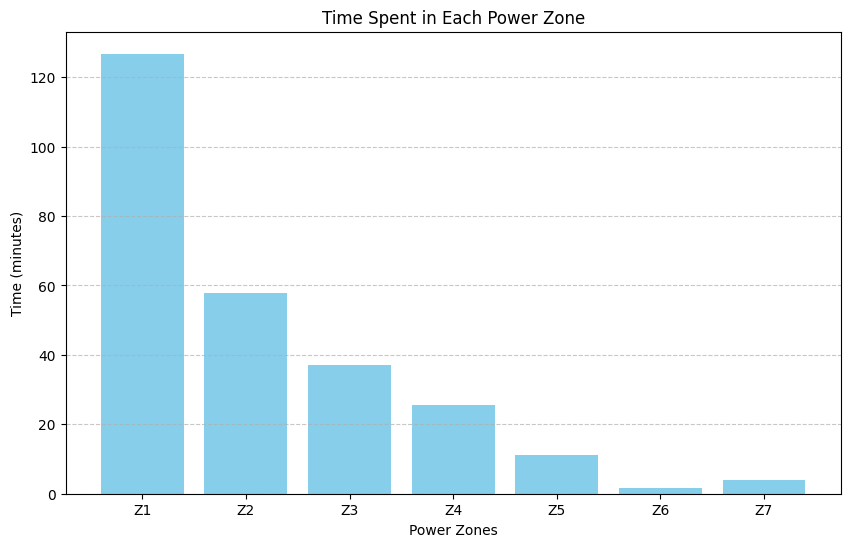

In [20]:
def visualize_zone_overlaps(aggregated_zones):
    """
    Visualizes time spent in each FTP-based zone.
    """
    zones = list(aggregated_zones.keys())
    times = [z["time_sec"] / 60 for z in aggregated_zones.values()]  # Convert to minutes

    plt.figure(figsize=(10, 6))
    plt.bar(zones, times, color='skyblue')
    plt.xlabel("Power Zones")
    plt.ylabel("Time (minutes)")
    plt.title("Time Spent in Each Power Zone")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
# ------------- Aggregate raw power zones into grouped FTP-based zones
last_activity, seven_day_avg, recent_avg, older_avg, all_time_avg, activity_counts, totals, cycling_data = prepare_performance_data(cycling_data)
aggregated_power_zones_last = aggregate_power_zones(last_activity, ftp_athlete, power_zones)
visualize_zone_overlaps(aggregated_power_zones_last)



---
Debugging end


## [Strava & Gemini] Generate contents for LLM Prompt

In [21]:
#@title [Function] Generate the Plots to integrate into Gemini

def plot_metrics(data):
    # Ensure the data is sorted in descending order by date
    data = data.sort_values('date', ascending=False)

    # Create a directory to save plots if it doesn't exist
    plot_dir = 'plots'
    os.makedirs(plot_dir, exist_ok=True)

    # Group by date and calculate the mean for numeric columns only
    numeric_columns = ['CTL', 'ACWR', 'form', 'training_stress_score', 'intensity_factor', 'weighted_average_watts', 'moving_time']
    grouped_data = data[['date'] + numeric_columns].groupby('date').mean().reset_index()

    # Plot Form
    plt.figure(figsize=(12, 6))
    plt.plot(grouped_data['date'], grouped_data['form'], marker='o', linestyle='-', color='blue')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Form', fontsize=12)
    plt.title('Fitness-Fatigue Balance (Form)', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    form_plot_path = os.path.join(plot_dir, 'form_plot.png')
    plt.savefig(form_plot_path)
    plt.show()  # Show the plot for debugging
    plt.close()

    # Plot ACWR
    plt.figure(figsize=(12, 6))
    plt.plot(grouped_data['date'], grouped_data['ACWR'], marker='o', linestyle='-', color='orange')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('ACWR', fontsize=12)
    plt.title('Acute-to-Chronic Workload Ratio (ACWR)', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    acwr_plot_path = os.path.join(plot_dir, 'acwr_plot.png')
    plt.savefig(acwr_plot_path)
    plt.show()  # Show the plot for debugging
    plt.close()

    # Plot CTL
    plt.figure(figsize=(12, 6))
    plt.plot(grouped_data['date'], grouped_data['CTL'], marker='o', linestyle='-', color='green')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('CTL', fontsize=12)
    plt.title('Chronic Training Load (CTL)', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    ctl_plot_path = os.path.join(plot_dir, 'ctl_plot.png')
    plt.savefig(ctl_plot_path)
    plt.show()  # Show the plot for debugging
    plt.close()

    # Plot IF
    plt.figure(figsize=(12, 6))
    plt.plot(grouped_data['date'], grouped_data['intensity_factor'], marker='o', linestyle='-', color='green')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('intensity_factor', fontsize=12)
    plt.title('Intesity Factor', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    intensity_factor_plot_path = os.path.join(plot_dir, 'intensity_factor_plot.png')
    plt.savefig(intensity_factor_plot_path)
    plt.show()  # Show the plot for debugging
    plt.close()

    # Plot TSS
    plt.figure(figsize=(12, 6))
    plt.plot(grouped_data['date'], grouped_data['training_stress_score'], marker='o', linestyle='-', color='green')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('training_stress_score', fontsize=12)
    plt.title('Training Stress Score', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    training_stress_score_plot_path = os.path.join(plot_dir, 'training_stress_score_plot.png')
    plt.savefig(training_stress_score_plot_path)
    plt.show()  # Show the plot for debugging
    plt.close()

    return form_plot_path, acwr_plot_path, ctl_plot_path, intensity_factor_plot_path, training_stress_score_plot_path

  and should_run_async(code)



In [22]:
#@title [Function] Generate Prompt for LLM (Gemini)
def generate_enhanced_prompt(last_activity, seven_day_avg, recent_avg, older_avg, all_time_avg, activity_counts,totals, df_stress):

    # ------------- HELPER: HR zone distribution for last_activity -------------
    hr_zone_dist_last = format_zone_distribution(
        last_activity,
        zone_time_prefix="hr_zone_time_",
        zone_pct_prefix="hr_zone_pct_",
        zone_type="Heart-Rate"
    )

    # ------------- HELPER:  HR zone distribution for 7-day average -------------
    hr_zone_dist_7D = format_zone_distribution(
        seven_day_avg,
        zone_time_prefix="hr_zone_time_",
        zone_pct_prefix="hr_zone_pct_",
        zone_type="Heart-Rate"
    )

   # ------------- Aggregate raw power zones into grouped FTP-based zones
    aggregated_power_zones_last = aggregate_power_zones(last_activity, ftp_athlete, power_zones)
    grouped_power_zone_dist_last = format_grouped_power_zones(aggregated_power_zones_last)

    # ------------ Aggregate raw power zones into grouped FTP-based zones for 7-day average
    aggregated_power_zones_7D = aggregate_power_zones(seven_day_avg, ftp_athlete, power_zones)
    grouped_power_zone_dist_7D = format_grouped_power_zones(aggregated_power_zones_7D)

    # ------------- Compute power/HR ratios as before -------------
    power_hr_ratio_last = f"{(last_activity['weighted_average_watts']/last_activity['average_heartrate']):.2f}" if last_activity['average_heartrate'] > 0 else "N/A"
    power_hr_ratio_7D = f"{(seven_day_avg['weighted_average_watts']/seven_day_avg['average_heartrate']):.2f}" if seven_day_avg['average_heartrate'] > 0 else "N/A"
    power_hr_ratio_30D = f"{(recent_avg['weighted_average_watts']/recent_avg['average_heartrate']):.2f}" if recent_avg['average_heartrate'] > 0 else "N/A"
    power_hr_ratio_60D = f"{(older_avg['weighted_average_watts']/older_avg['average_heartrate']):.2f}" if older_avg['average_heartrate'] > 0 else "N/A"

    # ------------- Determine Season for Context -------------
    season = pd.Timestamp(last_activity['start_date']).month
    season_context = "winter base training" if season in [12, 1, 2] else \
                    "spring build phase" if season in [3, 4, 5] else \
                    "summer peak season" if season in [6, 7, 8] else "fall transition"


    # Sort the dataframe df_stress from newest to oldest training day
    df_stress = df_stress.sort_values(by='start_date', ascending=False).reset_index(drop=True)

    # ------------- Calculate stress metrics and Fitness -------------

    # Extract metrics for CTL and ACWR analysis
    latest_metrics = df_stress.iloc[0]  # Last day
    def get_historical_metrics(df_stress, days_from_last):
        """Retrieve historical metrics with interpolation fallback."""
        historical_data = df_stress[df_stress['days_from_last'] == days_from_last]
        if len(historical_data) > 0:
            return historical_data.iloc[0]
        elif len(df_stress) > 0:
            # Interpolate or use rolling average as fallback
            return df_stress[df_stress['days_from_last'] <= days_from_last].iloc[-1]
        else:
            return None

    week_ago_metrics = get_historical_metrics(df_stress, 7)
    month_ago_metrics = get_historical_metrics(df_stress, 30)

    # week_ago_metrics = df_stress[df_stress['days_from_last'] == 7].iloc[0] if len(df_stress[df_stress['days_from_last'] == 7]) > 0 else df_stress[df_stress['days_from_last'] == 8].iloc[0] if len(df_stress[df_stress['days_from_last'] == 8]) else None
    # month_ago_metrics = df_stress[df_stress['days_from_last'] == 30].iloc[0] if len(df_stress[df_stress['days_from_last'] == 30]) > 0 else df_stress[df_stress['days_from_last'] == 31].iloc[0] if len(df_stress[df_stress['days_from_last'] == 31]) else None

    # Calculate weekly TSS
    weekly_tss = df_stress[df_stress['days_from_last'] <= 7]['training_stress_score'].sum()

    # Pre-calculate CTL context
    ctl_context = ('Very High (120+)' if latest_metrics['CTL'] >= 120
                  else 'High (100-120)' if latest_metrics['CTL'] >= 100
                  else 'Moderate (80-100)' if latest_metrics['CTL'] >= 80
                  else 'Low (60-80)' if latest_metrics['CTL'] >= 60
                  else 'Very Low (<60)')

    # Pre-calculate ACWR status
    acwr = latest_metrics['ACWR']
    acwr_status = ('High risk' if acwr > 1.5
                   else 'Optimal' if 0.8 <= acwr <= 1.3
                   else 'Undertraining risk')

    # Pre-calculate Training Status
    training_status = ('Peak Training (700+)' if weekly_tss >= 700
                      else 'Building Fitness (450-700)' if weekly_tss >= 450
                      else 'Maintenance (300-450)' if weekly_tss >= 300
                      else 'Low Volume (<300)')

    # Calculate EMA trends for CTL and ACWR
    def calculate_ema_trend(data, column, days_range, smoothing=2):
        filtered_data = data[data['days_from_last'] <= days_range]
        if len(filtered_data) == 0:
            return None, None

        ema = filtered_data[column].ewm(span=days_range, adjust=False).mean()
        trend = latest_metrics[column] - ema.iloc[-1]

        return trend, ema.iloc[-1]

    ctl_week_trend, ctl_week_ema = calculate_ema_trend(df_stress, 'CTL', 7)
    ctl_month_trend, ctl_month_ema = calculate_ema_trend(df_stress, 'CTL', 30)

    acwr_week_trend, acwr_week_ema = calculate_ema_trend(df_stress, 'ACWR', 7)
    acwr_month_trend, acwr_month_ema = calculate_ema_trend(df_stress, 'ACWR', 30)

    # Describe trends
    def describe_trend(trend, metric):
        if trend is None:
            return "Insufficient data"
        if metric == 'CTL':
            if trend > 5:
                return f"Rapidly increasing (+{trend:.1f})"
            elif trend > 0:
                return f"Gradually increasing (+{trend:.1f})"
            elif trend > -5:
                return f"Slightly decreasing ({trend:.1f})"
            else:
                return f"Rapidly decreasing ({trend:.1f})"
        elif metric == 'ACWR':
            if trend > 0.2:
                return f"Sharply rising (+{trend:.2f})"
            elif trend > 0:
                return f"Slowly rising (+{trend:.2f})"
            elif trend > -0.2:
                return f"Slowly falling ({trend:.2f})"
            else:
                return f"Sharply falling ({trend:.2f})"

    ctl_week_trend_description = describe_trend(ctl_week_trend, 'CTL')
    ctl_month_trend_description = describe_trend(ctl_month_trend, 'CTL')
    acwr_week_trend_description = describe_trend(acwr_week_trend, 'ACWR')
    acwr_month_trend_description = describe_trend(acwr_month_trend, 'ACWR')

    # Calculate Training Monotony and Strain
    # metric added on 10 Feb
    daily_tss = df_stress[df_stress['days_from_last'] <= 30]['training_stress_score']
    mean_tss = daily_tss.mean()
    std_tss = daily_tss.std()
    training_monotony = mean_tss / std_tss if std_tss > 0 else None
    training_strain = training_monotony * weekly_tss if training_monotony else None

    # Today is:
    today = datetime.date.today()
    today_str = today.strftime('%Y-%m-%d')

    # ------------- Trainings ---------------------- #

    training_knowledge = f"""
    # Professional Cycling Team Workouts

    ## Workout Summary Table ofr outdoor trainings:

    | Workout Name | Duration (min) | Training Focus | Intensity Level | Key Intervals |
    |--------------|----------------|-----------------|-----------------|---------------|
    | Team DSM - Over Under | 180 | Threshold/VO2max | High | 30s @ 120-125% FTP, 90s @ 85% FTP |
    | Team Total Energies Threshold | 184 | Threshold | Moderate-High | 18min sets @ 90-100% FTP |
    | Team Israel - Over Under | 148 | Threshold/VO2max | High | 30s @ 130% FTP, 90s @ 90% FTP |
    | Team DSM - Over Under (Less Trained) | 90 | Threshold/VO2max | Moderate-High | 30s @ 120% FTP, 90s @ 80% FTP |
    | Team INEOS Vo2max | 127 | VO2max | Very High | 30s @ 115% FTP, 15s @ 80% FTP |
    | Team INEOS Vo2max (Less Trained) | 103 | VO2max | High | 30s @ 115% FTP, 15s @ 80% FTP |
    | Team Visma - Over Under | 150 | Threshold/VO2max | Very High | 15s @ 140% FTP, 6min @ 85% FTP |
    | Team INEOS Vo2max (Highly Trained) | 170 | VO2max | Very High | 30s @ 115% FTP, 15s @ 80% FTP |
    | Team Visma - Over Under (Medium Trained) | 100 | Threshold/VO2max | High | 15s @ 140% FTP, 6min @ 85% FTP |
    | Team Groupama - Threshold | 150 | Threshold | Moderate-High | 8min @ 95% FTP, 2min @ 60-65% FTP |
    | Team UNO-X - Threshold Vo2max | 147 | Threshold/VO2max | High | Progressive 6-4min blocks from 90% to 115% FTP |
    | Team Total Energies Threshold (Highly Trained) | 299 | Threshold | High | 18min sets @ 90-100% FTP |
    | Team UNO-X - Threshold Vo2max (Highly Trained) | 180 | Threshold/VO2max | Very High | Progressive 11-4min blocks from 90% to 115% FTP |
    | Team Total Energies Threshold (Medium Trained) | 150 | Threshold | Moderate-High | 14min sets @ 90-100% FTP |
    | Team Alpecin - Vo2max | 186 | VO2max | Very High | 30s @ 135% FTP, 120s @ 100-105% FTP |
    | Team UNO-X - Threshold Vo2max (Less Trained) | 122 | Threshold/VO2max | Moderate-High | Progressive 8-3min blocks from 90% to 105% FTP |
    | Team Israel - Over Under (Less Trained) | 120 | Threshold/VO2max | High | 30s @ 125% FTP, 90s @ 90% FTP |
    | Team Visma (Highly Trained) | 131 | Mixed | Very High | 20s @ 150% FTP, 4min @ 105-110% FTP |
    | Team Alpecin - Vo2max (Highly Trained) | 296 | VO2max | Very High | 30s @ 135% FTP, 120s @ 100-105% FTP |
    | Team Lidl-Trek Vo2max | 141 | VO2max | Very High | 60s @ 130% FTP, 240s @ 110-120% FTP |
    | Team Alpecin - Vo2max (Less Trained) | 118 | VO2max | High | 30s @ 125% FTP, 120s @ 100-105% FTP |
    | Team Total Energies Threshold (Less Trained) | 120 | Threshold | Moderate | 15min sets @ 90-100% FTP |
    | Team Groupama - Threshold (Highly Trained) | 180 | Threshold | High | 8min @ 95% FTP, 2min @ 60-65% FTP |
    | Team DSM - Over Under (Medium Trained) | 110 | Threshold/VO2max | High | 30s @ 120% FTP, 90s @ 80% FTP |
    | Team Lidl-Trek Vo2max (Less Trained) | 123 | VO2max | High | 60s @ 130% FTP, 180s @ 110% FTP |
    | Team Israel - Over Under (Highly Trained) | 328 | Threshold/VO2max | Very High | 30s @ 130% FTP, 90s @ 90% FTP |
    | Team Visma (Original Highly Trained) | 254 | Mixed | Very High | 20s @ 150% FTP, 4min @ 105-110% FTP |
    | Team Visma - Over Under (Less Trained) | 80 | Threshold/VO2max | High | 15s @ 140% FTP, 6min @ 85% FTP |
    | Team Groupama - Threshold (Original Highly Trained) | 310 | Threshold | High | 8min @ 95% FTP, 2min @ 60-65% FTP |
    | Team UNO-X - Threshold Vo2max (Medium Trained) | 147 | Threshold/VO2max | High | Progressive 10-4min blocks from 90% to 108% FTP |
    | Team Total Energies Threshold (Original Highly Trained) | 299 | Threshold | High | 18min sets @ 90-100% FTP |
    | Team Alpecin - Vo2max (Short Highly Trained) | 186 | VO2max | Very High | 30s @ 135% FTP, 120s @ 100-105% FTP |
    | Team Visma (Medium Trained) | 122 | Mixed | High | 20s @ 150% FTP, 4min @ 105-110% FTP |
    | Team Lidl-Trek Vo2max (Medium Trained) | 141 | VO2max | High | 60s @ 130% FTP, 240s @ 110-120% FTP |
    | Team Alpecin - Vo2max (Original Highly Trained) | 296 | VO2max | Very High | 30s @ 135% FTP, 120s @ 100-105% FTP |

    ## General Instructions for Executing These Trainings on the Road

    1. **Preparation**:
      - Bring sufficient water and nutrition for the duration of the ride.
      - Choose a route that allows for uninterrupted intervals (minimal traffic, stop signs, etc.).
      - Use a cycling computer or smartphone app to track your power output and time.

    2. **Warm-up**:
      - Always begin with the specified warm-up to prepare your body for the intense work ahead.
      - Gradually increase your effort during the warm-up period.

    3. **Main Set Execution**:
      - Follow the prescribed power targets closely. If you don't have a power meter, use perceived exertion or heart rate as a guide.
      - Maintain a consistent cadence (usually 90-100 rpm) during high-intensity intervals.
      - For over-under workouts, focus on smooth transitions between intensities.
      - Use flat or rolling terrain for threshold work, and hills for VO2max intervals if possible.

    4. **Recovery Periods**:
      - Actively recover between intervals at the specified power or 50-60% of FTP.
      - Use longer rest periods between sets to hydrate and fuel if necessary.

    5. **Cool-down**:
      - Always include the specified cool-down to gradually bring your heart rate down and begin the recovery process.

    6. **Adaptations**:
      - If you're new to structured training, start with the less trained versions of workouts.
      - Progress to medium trained and highly trained versions as your fitness improves.
      - Adjust the number of repetitions or sets based on your available time and fitness level.

    7. **Safety**:
      - Be aware of your surroundings and traffic at all times.
      - It's okay to interrupt an interval for safety reasons; resume when it's safe to do so.

    8. **Post-Workout**:
      - Hydrate and refuel properly after the session.
      - Record your workout data and notes on how you felt for future reference.

    Remember, consistency is key in training. Regular execution of these workouts, combined with proper rest and recovery, will lead to significant improvements in your cycling performance over time.

    ## Specific Workout Execution Guidelines

    ### Threshold Workouts (e.g., Team Total Energies, Team Groupama):
    - Focus on maintaining a steady, sustainable power output.
    - Aim for a cadence of 85-95 rpm.
    - These are best performed on flat to rolling terrain.
    - Mental focus is crucial for maintaining effort over extended periods.

    ### VO2max Workouts (e.g., Team INEOS, Team Alpecin):
    - These are high-intensity, shorter duration efforts.
    - Maintain a high cadence (95-105 rpm) during the hard efforts.
    - Full recovery between intervals is crucial.
    - Can be performed on varied terrain, including hills.

    ### Over-Under Workouts (e.g., Team DSM, Team Israel, Team Visma):
    - Focus on smooth transitions between the over (above threshold) and under (below threshold) segments.
    - These workouts simulate race situations and require concentration.
    - Can be performed on rolling terrain to naturally vary the intensity.

    ### Progressive Workouts (e.g., Team UNO-X):
    - Start at a manageable intensity and gradually increase throughout the workout.
    - Pay close attention to pacing to ensure you can complete the entire session.
    - These are mentally challenging and great for developing fatigue resistance.

    ### Mixed Workouts (e.g., Team Visma Highly Trained):
    - These combine different types of intervals and intensities.
    - Require good pacing and the ability to switch between energy systems.
    - Great for overall fitness and race preparation.

    ## Tips for Different Training Levels

    ### Less Trained:
    - Focus on completing the workouts at the prescribed intensities, even if you need to reduce the duration or number of intervals.
    - Pay extra attention to recovery between workouts.
    - Don't be afraid to extend rest intervals if needed.

    ### Medium Trained:
    - Aim to complete the full workout as prescribed.
    - Start incorporating some of the more challenging aspects, like reducing rest intervals or increasing the number of repetitions.

    ### Highly Trained:
    - Challenge yourself with the full duration and intensity of these demanding workouts.
    - Focus on the quality of each interval, maintaining proper form and power output even when fatigued.
    - Consider combining some of these workouts into longer, race-specific training blocks.

    The provided workouts offer glimpses into professional cycling training methodologies, but they lack crucial context and completeness.  The summary tables are inaccurate and don't reflect the actual workout structure. Let's break down the provided workouts and then expand on them to create a more comprehensive training plan library for an AI agent.

    [Indoor trainings - On Turbo Trainer with Zwift, Woosh or similar]
    In case you need to think about indoor traininings (the user may ask suggestion due to weather conditions or time available) leverage the following workout suggestions for indoor training:
    **Workout 1: Team DSM indoor (4x5min 90%FTP 65rpm)**

    This workout focuses on threshold development with 4x5min intervals at 90% FTP. The prescribed cadence of 65 rpm suggests a focus on muscular force production.  The warm-up and cool-down are adequate. However, the summary table is incorrect.

    **Workout 2: Team Uno-X indoor (2X10m Fatmax - 6x40s 115/120%ftp)**

    This workout is more complex, aiming to improve both aerobic capacity (Fatmax intervals) and anaerobic power (short, high-intensity sprints). The warm-up is progressive, which is good practice. The description hints at adaptability, a key aspect of effective training. Again, the summary table is inaccurate and doesn't reflect the workout structure.

    ## Summary Table of Provided Workouts (Corrected)

    | Workout Name | Focus | Key Intervals | Warm-up (min) | Cool-down (min) | Total Duration (min) |
    |---|---|---|---|---|---|
    | Team DSM Indoor | Threshold | 4 x 5 min @ 90% FTP (65 rpm) | 15 | 20 | 35 |
    | Team Uno-X Indoor | Fatmax & Anaerobic Capacity | 2 x 10 min @ Fatmax, 6 x 40s @ 115/120% FTP | ~15 | 20 | 95 |

    ## Executing Workouts on Indoor Trainers (Zwift/TrainingPeaks)

    These workouts can be easily executed on platforms like Zwift or TrainingPeaks:

    1. **Using Zwift:**  Create custom workouts within Zwift or import them from TrainingPeaks. Zwift's ERG mode automatically adjusts resistance to maintain the target power, making it ideal for structured workouts.  Select a suitable virtual course or simply ride in free-ride mode while following the workout.
    2. **Using TrainingPeaks:** Create structured workouts within TrainingPeaks and sync them to your cycling computer or smart trainer. TrainingPeaks offers detailed analysis and tracking of your performance.

    **Instructions for Execution:**

    * **Warm-up:** Start with easy spinning, gradually increasing intensity to prepare your muscles and cardiovascular system.
    * **Main Set:** Focus on maintaining the prescribed power and cadence for each interval. Use ERG mode if available.
    * **Rest Intervals:** Spin easily during rest periods to promote recovery.
    * **Cool-down:**  Gradually decrease intensity to allow your body to return to its resting state.
    * **Hydration and Nutrition:**  Ensure adequate hydration and nutrition before, during, and after the workout.

    Remember, proper execution of these workouts is more important than simply completing them. Always listen to your body and adjust as necessary. Consistent, quality training will lead to the best results over time.
    """

    # ------------- Knowledge basics ---------------------- #

    basic_knowledge = f"""
    # Cycling Performance and Training Knowledge Base

    ## Power Output Metrics
    ### FTP Averages by Cyclist Population
    - Low-trained: 2.0-2.5 W/kg
    - Medium-trained: 2.5-3.5 W/kg
    - High-trained: 3.5-4.5 W/kg
    - Professional: 4.5+ W/kg up to 6+ W/kg

    ## Power Zones
    1. Zone 1 (Active Recovery): <55% FTP
    2. Zone 2 (Endurance): 56-75% FTP
    3. Zone 3 (Tempo): 76-90% FTP
    4. Zone 4 (Lactate Threshold): 91-105% FTP
    5. Zone 5 (VO2 Max): 106-120% FTP
    6. Zone 6 (Anaerobic Capacity): >120% FTP

    ## Key Performance Indicators (KPIs)

    ### VO2max
    - Professional male cyclists: 70-80 ml/kg/min
    - Professional female cyclists: 60-70 ml/kg/min
    - Well-trained male cyclists: 62.2 ± 5.4 ml/kg/min

    ### Other Important KPIs
    1. Functional Threshold Power (FTP)
    2. Power-to-Weight Ratio
    3. Ventilatory Thresholds (VT1 and VT2)
    4. Cycling Economy

    ## Training Load and Volume
    - Professional cyclists in grand tours:
      - 13.0 ± 2.7 km/day
      - 3,762 ± 765 calories/day
    - Longer stages: Predominantly Z1-Z3
    - Shorter stages: More time in Z4-Z7

    ## High-Intensity Interval Training (HIIT)
    - Typical session:
      - Warm-up: 10-15 minutes at low intensity
      - Intervals: 6-8 repetitions of 1-minute high-intensity efforts (80-95% VO2max) alternated with 1-minute active recovery (25-30% VO2max)
      - Cool-down: 10-15 minutes at low intensity
    - Benefits: Improved VO2max, peak power output, lactate threshold, and fat oxidation

    ### Recommendations on Training Monotony
    - Maintain current variability while monitoring for signs of excessive fatigue.
    - If monotony increases (>2.0), introduce more variation by alternating high-intensity and recovery days.
    - If monotony decreases (<1.5), aim for more consistent workloads by reducing large fluctuations in daily stress.

    ## Training Strategies

    ### Professional Cyclists
    1. Periodization
    2. High volume of low-intensity training (60-80% of total training time)
    3. Regular performance testing
    4. Strength training
    5. Altitude training camps

    ### Amateur Cyclists
    1. Gradual increase in training volume and intensity
    2. Focus on building aerobic base
    3. 1-2 HIIT sessions per week
    4. Use of indoor training tools
    5. Prioritize recovery and nutrition

    ## Environmental Factors
    - Optimal temperature:
      - Males: 10-30°C
      - Females: 5-25°C
    - Performance impairment at extreme temperatures (<5°C and >35°C): -18% to -9%

    ## Nutritional Strategies
    - Average fluid intake: 0.74 ± 0.28 L/h during training
    - Carbohydrate intake planning: 56% to 80% of participants
    - Optimal glucose-to-fructose ratio: 2:1
    - High-intensity cycling: 90 g/h carbohydrate intake (2:1 glucose-to-fructose)

    ## Indoor vs. Outdoor Cycling
    - Similar physiological responses and performance metrics
    - Indoor cycling may have higher mental demand
    - Environmental factors influence outdoor performance

    ## Fatigue and Recovery
    - Performance decline: ~2.9% after 40 kJ/kg of work
    - Rest days crucial during stage races

    ## Injury and Illness Rates
    - Racing injury rate: 4.14 per 1000 h of exposure (95% CI: 2.65–5.79)
    - Training injury rate: 1.23 per 1000 h (95% CI: 0.8–1.7)

    ## Key Principles for Cyclists
    1. Optimize energy availability and nutrition
    2. Implement diverse training strategies
    3. Regularly monitor performance metrics
    4. Prioritize recovery
    5. Prevent injuries
    6. Adapt to environmental conditions
    7. Individualize training approaches
    """

    # ------------- TSS Section Prompt ------------- #
    tss_analysis = f"""
    Current Training Status (as of {latest_metrics['start_date'].strftime('%Y-%m-%d')}):

    1. Weekly Training Stress Score (TSS): {weekly_tss:.1f}
    - Status: {training_status}

    2. Chronic Training Load (CTL): {latest_metrics['CTL']:.1f}
    - Context: {ctl_context}
    - Weekly Trend: {ctl_week_trend_description} (7-day EMA: {ctl_week_ema:.1f})
    - Monthly Trend: {ctl_month_trend_description} (30-day EMA: {ctl_month_ema:.1f})
    {f"- Change from last week: {latest_metrics['CTL'] - week_ago_metrics['CTL']:.1f} points" if week_ago_metrics is not latest_metrics else "- Weekly change: No data available for comparison"}
    {f"- Change from last month: {latest_metrics['CTL'] - month_ago_metrics['CTL']:.1f} points" if month_ago_metrics is not latest_metrics else "- Monthly change: No data available for comparison"}

    3. Acute to Chronic Workload Ratio (ACWR): {acwr:.2f}
    - Status: {acwr_status}
    - Weekly Trend: {acwr_week_trend_description} (7-day EMA: {acwr_week_ema:.2f})
    - Monthly Trend: {acwr_month_trend_description} (30-day EMA: {acwr_month_ema:.2f})
    {f"- Change from last week: {latest_metrics['ACWR'] - week_ago_metrics['ACWR']:.2f}" if week_ago_metrics is not latest_metrics else "- Weekly change: No data available for comparison"}
    {f"- Change from last month: {latest_metrics['ACWR'] - month_ago_metrics['ACWR']:.2f}" if month_ago_metrics is not latest_metrics else "- Monthly change: No data available for comparison"}

    4. Form (Training Stress Balance):
    - Current Form: {latest_metrics['form']:.1f}
    {f"- Last Week Form: {week_ago_metrics['form']:.1f}" if week_ago_metrics is not latest_metrics else "- Last Week Form: No data available"}
    {f"- Last Month Form: {month_ago_metrics['form']:.1f}" if month_ago_metrics is not latest_metrics else "- Last Month Form: No data available"}
    {f"- Weekly Form Change: {latest_metrics['form'] - week_ago_metrics['form']:.1f}" if week_ago_metrics is not latest_metrics else "- Weekly Form Change: No data available"}
    {f"- Monthly Form Change: {latest_metrics['form'] - month_ago_metrics['form']:.1f}" if month_ago_metrics is not latest_metrics else "- Monthly Form Change: No data available"}

    5. Training Monotony: {training_monotony:.2f}
    6. Training Strain: {training_strain:.2f}

    Form Analysis:
    - Current Status: {'Fresh/Recovery' if latest_metrics['form'] > 5 else 'Optimal Race Form' if -10 <= latest_metrics['form'] <= 5 else 'High Fatigue'}
    - Week Trend: {('Improving' if latest_metrics['form'] > week_ago_metrics['form'] else 'Declining') if week_ago_metrics is not latest_metrics else 'Insufficient data'}
    - Month Trend: {('Improving' if latest_metrics['form'] > month_ago_metrics['form'] else 'Declining') if month_ago_metrics is not latest_metrics else 'Insufficient data'}

    Note: Form values indicate training readiness:
    * Above +5: Well rested, possibly losing fitness
    * -10 to +5: Optimal range for performance
    * Below -10: Accumulated fatigue, recovery needed
    """

    # ------------- Generate Final Prompt -------------
    prompt = f"""
    - Evaluate in the context of {season_context}, provide an initial assessement and prepare to follow-up with any question the Athlete may ask.
    Today is {today_str}.
    **Activity Summary for the Athlete {AthleteName}:**
    [Declared Athlete FTP: {last_activity['FTP_athlete']:.0f}W]

    - {activity_counts['last_7_days']} rides in last 7 days,
    - {activity_counts['last_30_days']} rides in last 30 days,
    - {activity_counts['previous_30_days']} rides in previous 30 to 60 days,
    - {activity_counts['total_activities']} total rides

    **[Totals section starts]**

    ** LAST 7 DAYS TRAINING TOTALS:
    - Total Distance: {totals['last_7_days']['distance_km']:.1f} km
    - Total Climb: {totals['last_7_days']['elevation_gain']:.1f} km
    - Total Duration: {totals['last_7_days']['moving_time']/3600:.1f} hours
    - Total Work Done: {totals['last_7_days']['kilojoules']:.0f} kJ
    - Training Stress Score: {totals['last_7_days']['training_stress_score']:.1f}

    ** LAST 30 DAYS TRAINING TOTALS: **
    - Total Distance: {totals['last_30_days']['distance_km']:.1f} km
    - Total Climb: {totals['last_30_days']['elevation_gain']:.1f} km
    - Total Duration: {totals['last_30_days']['moving_time']/3600:.1f} hours
    - Total Work Done: {totals['last_30_days']['kilojoules']:.0f} kJ
    - Training Stress Score: {totals['last_30_days']['training_stress_score']:.1f}

    ** PREVIOUS 30 DAYS TRAINING TOTALS (LAST 30 to LAST 60 DAYS): **
    - Total Distance: {totals['previous_30_days']['distance_km']:.1f} km
    - Total Climb: {totals['previous_30_days']['elevation_gain']:.1f} km
    - Total Duration: {totals['previous_30_days']['moving_time']/3600:.1f} hours
    - Total Work Done: {totals['previous_30_days']['kilojoules']:.0f} kJ
    - Training Stress Score: {totals['previous_30_days']['training_stress_score']:.1f}

    **[Totals section ends]**

    #############################################################
    ** 1. LATEST RIDE COMPLETE ANALYSIS ({last_activity['date'].strftime('%Y-%m-%d')}): **
    We now look at the last ride completed by the Athlete.
    Remember to check the date, if the Athlete last training day was one or more days before today {today_str}, then you should consider that potentialially resting days.
    **Primary Metrics of the last training session:**
    - Activity Type: {last_activity['activity_type']}
    - Distance: {last_activity['distance_km']:.1f} km
    - Duration: {last_activity['moving_time']/3600:.1f} hours
    - Normalized Power: {last_activity['weighted_average_watts']:.0f}W
    - Heart Rate: {last_activity['average_heartrate']:.0f} bpm
    - Cadence: {last_activity['average_cadence']:.0f} rpm
    - Elevation Gain: {last_activity['elevation_gain']:.0f}m
    - Work Done: {last_activity['kilojoules']:.0f} kJ
    - Suffer Score: {last_activity['suffer_score']:.0f}
    - Intensity Factor: {last_activity['intensity_factor']:.2f}
    - Training Stress Score: {last_activity['training_stress_score']:.1f}
    - Power/HR Ratio: {power_hr_ratio_last} (aerobic efficiency indicator)
    - Aggregated Power Zones (Grouped in Z definition based on FTP {last_activity['FTP_athlete']:.0f}W):
    {grouped_power_zone_dist_last}
    -----------------------------
    - {hr_zone_dist_last}

    **[Averages section starts]**

    #############################################################
    ** 2. PERFORMANCE LAST 7 DAYS TRAINING AVERAGES: **
    Tips: weekly totals are very important for the athlete, especially hours, kms, KJs, TSS and power zones focus.
    We now look at last 7 days averages to assess the weekly work done and performance.
    Last 7 Days Average ({activity_counts['last_7_days']} rides):
    - Distance: {seven_day_avg['distance_km']:.1f} km/ride
    - Duration: {seven_day_avg['moving_time']/3600:.1f} hours/ride
    - Normalized Power: {seven_day_avg['weighted_average_watts']:.0f}W
    - Heart Rate: {seven_day_avg['average_heartrate']:.0f} bpm
    - Cadence: {seven_day_avg['average_cadence']:.0f} rpm
    - Elevation Gain: {seven_day_avg['elevation_gain']:.0f}m
    - Work Done: {seven_day_avg['kilojoules']:.0f} kJ/ride
    - Suffer Score: {seven_day_avg['suffer_score']:.1f}
    - Intensity Factor: {seven_day_avg['intensity_factor']:.2f}
    - Training Stress Score: {seven_day_avg['training_stress_score']:.1f}
    - Power/HR Ratio: {power_hr_ratio_7D}
    - Aggregated Power Zones (Grouped in Z definition based on FTP {last_activity['FTP_athlete']:.0f}W) averages:
    {grouped_power_zone_dist_7D}
    -----------------------------
    - {hr_zone_dist_7D}

    #############################################################
    ** 3. PERFORMANCE LAST 30 DAYS TRAINING AVERAGES: **
    We now look at the last completed month averages considering the current season (cycling sport) is {season_context}.
    Last 30 Days Average ({activity_counts['last_30_days']} rides):
    - Distance: {recent_avg['distance_km']:.1f} km/ride
    - Duration: {recent_avg['moving_time']/3600:.1f} hours/ride
    - Normalized Power: {recent_avg['weighted_average_watts']:.0f}W
    - Heart Rate: {recent_avg['average_heartrate']:.0f} bpm
    - Cadence: {recent_avg['average_cadence']:.0f} rpm
    - Elevation Gain: {recent_avg['elevation_gain']:.0f}m
    - Work Done: {recent_avg['kilojoules']:.0f} kJ/ride
    - Suffer Score: {recent_avg['suffer_score']:.1f}
    - Intensity Factor: {recent_avg['intensity_factor']:.2f}
    - Training Stress Score: {recent_avg['training_stress_score']:.1f}
    - Power/HR Ratio: {power_hr_ratio_30D}

    #############################################################
    ** 4. PERFORMANCE PREVIOUS 30 DAYS TRAINING AVERAGES (LAST 30 to LAST 60 DAYS): **
    We now look at the previous completed month averages before the last closed month (last 30 to 60 days).
    Previous 30 to 60 days avergaes ({activity_counts['previous_30_days']} rides):
    - Distance: {older_avg['distance_km']:.1f} km/ride
    - Duration: {older_avg['moving_time']/3600:.1f} hours/ride
    - Normalized Power: {older_avg['weighted_average_watts']:.0f}W
    - Heart Rate: {older_avg['average_heartrate']:.0f} bpm
    - Cadence: {older_avg['average_cadence']:.0f} rpm
    - Elevation Gain: {older_avg['elevation_gain']:.0f}m
    - Work Load: {older_avg['kilojoules']:.0f} kJ/ride
    - Suffer Score: {older_avg['suffer_score']:.1f}
    - Intensity Factor: {older_avg['intensity_factor']:.2f}
    - Training Stress Score: {older_avg['training_stress_score']:.1f}
    - Power/HR Ratio: {power_hr_ratio_60D}

    #############################################################
    ** 5. TRAINING EVOLUTION INDICATORS (aggregated averages comparison): **
    Tips: we pre-computed change in averages to detect any important insight, validate the training execution depending on the season.
    Latest training sessions vs Recent Trend of last 7 days (the last training depends on current season and traing plan, it's expected to observe higher/lower values compared to last 7 days aggregated average):
    - Power expressed: Latest {last_activity['weighted_average_watts']:.0f}W vs 7-days avg {seven_day_avg['weighted_average_watts']:.0f}W
    - Cardiovascular Load: Latest {last_activity['average_heartrate']:.0f} bpm vs 7-days avg {seven_day_avg['average_heartrate']:.0f} bpm
    - Endurance Build: Latest {last_activity['moving_time']/3600:.1f} hours vs 7-days avg {seven_day_avg['moving_time']/3600:.1f} hours
    - Training Load: Latest {last_activity['kilojoules']:.0f} kJ vs 7-days avg {seven_day_avg['kilojoules']:.0f} kJ
    - Fatigue Response: Latest {last_activity['suffer_score']:.1f} vs 7-days avg {seven_day_avg['suffer_score']:.1f}
    - Intensity Factor: Latest {last_activity['intensity_factor']:.2f} vs 7-days avg {seven_day_avg['intensity_factor']:.2f}
    - Training Stress Score: Latest {last_activity['training_stress_score']:.1f} vs 7-days avg {seven_day_avg['training_stress_score']:.1f}
    - Power/HR Ratio: Latest {power_hr_ratio_last} vs 7-days avg {power_hr_ratio_7D}

    Seasonal Context (last 30 days vs previous 30 day: last 0-30 days vs last 31 to 60 days) Analysis for {season_context}:
    - Power expressed: {(recent_avg['weighted_average_watts'] - older_avg['weighted_average_watts']):.1f}W change
    - Cardiovascular Adaptation: {(recent_avg['average_heartrate'] - older_avg['average_heartrate']):.1f} bpm change
    - Endurance Build: {(recent_avg['moving_time'] - older_avg['moving_time'])/3600:.1f} hours change
    - Training Load: {(recent_avg['kilojoules'] - older_avg['kilojoules']):.0f} kJ change
    - Fatigue Response: {(recent_avg['suffer_score'] - older_avg['suffer_score']):.1f} suffer score change
    - Intensity Factor: {(recent_avg['intensity_factor'] - older_avg['intensity_factor']):.2f}
    - Training Stress Score: {(recent_avg['training_stress_score'] - older_avg['training_stress_score']):.1f} change
    - Power/HR Ratio: Latest 30-days avg {power_hr_ratio_30D} vs previous 30-days avg {power_hr_ratio_60D}

    **[Averages section ends]**

    #############################################################
    * 6. TRAINING STRESS SCORE (TSS) ANALYSIS: *
    {tss_analysis}


    ** DICTIONARY FOR INTERPRETING STRESS SPECIFIC METRICS **
    > Training Monotony:
    >> Training monotony measures how consistent or variable your daily training loads are over time. A value of 1.87 indicates moderate variability, which is ideal for balancing adaptation and recovery.
    >> If monotony becomes too high (>2.0), it may signal repetitive training patterns that could increase injury risk or mental fatigue.
    >> If monotony is too low (<1.5), it might indicate irregular training patterns that could hinder consistent progress.
    > Training Strain:
    >> Training strain reflects the cumulative stress from your recent training workload, combining both volume and consistency.
    >> A strain value of 1938.19 suggests a high workload, typical during intense training phases like building or peaking.
    >> This level of strain requires adequate recovery to ensure continued adaptation and prevent overtraining.

    > Chronic Training Load (CTL):
    >> Represents the long-term training load and overall fitness.
    >> Calculated as an exponentially weighted moving average of daily Training Stress Score (TSS) over the past 42 days.
    >> Indicates the athlete's capacity to perform work over time.
    > Acute to Chronic Workload Ratio (ACWR):
    >> Compares recent training load (acute) to longer-term training load (chronic).
    >> Calculated by dividing the 7-day average TSS by the 28-day average TSS.
    >> Helps assess if an athlete is at risk of overtraining or undertraining.
    >> A safe range is typically between 0.8 and 1.3.
    > Training Stress Score (TSS):
    >> Quantifies the overall training load of a workout.
    >> Based on the intensity and duration of the activity.
    >> Calculated using Intensity Factor and duration of the ride.
    > Intensity Factor (IF):
    >> Measures the relative intensity of a workout compared to the athlete's Functional Threshold Power (FTP).
    >> Calculated by dividing Normalized Power by FTP.

    ** RANGES TO EVALUTE CONSIDERING A DEVELOPED CYCLIST (less developed cyclist may have different ranges): **
    > Chronic Training Load (CTL)
    >> Low: 60-80
    >> Moderate: 80-100
    >> High: 100-120
    >> Very High: 120+

    > Acute to Chronic Workload Ratio (ACWR)
    >> Optimal range: 0.8-1.3
    >> High risk of injury: >1.5
    >> Undertraining risk: <0.8

    > Training Stress Score (TSS) per week
    >> Maintenance: 300-450
    >> Building fitness: 450-700
    >> Peak training: 700-1000+

    > Intensity Factor (IF)
    >> Recovery rides: 0.55-0.75
    >> Endurance rides: 0.75-0.85
    >> Tempo rides: 0.85-0.95
    >> Threshold workouts: 0.95-1.05
    >> VO2 max intervals: 1.05-1.15

    #############################################################
    * 7. TRAINING KNOWLEDGE REPOSITORY: *
    You are now provided with a repository of trainings suited for pro-cyclists. For each trainign type you can find versions dedicated to low/medium/highly trained cyclists.
    Use this knowledge to adapt you training suggestions to the Athlete, this will make you look like the best cycling coach in the world.
    It's on you to infeer if the Athlete is low, medium or highly trained, depending on the data you just processed (last training, weekly and monthly trends).
    Remember: these are specific, detailes training that a cyclist may execute 2-3 times per week, usually along with rest days or training days with majority of the time spent in Z2 power zone.

    {training_knowledge}

    #############################################################
    * 8. SCIENCE IN CYCLING, YOUR KNOWLEDGE BASICS: *
    {basic_knowledge}

    #############################################################
    Focus you assessement considering that the current season (cycling sport) is {season_context}:
    - Winter Base: Power should gradually increase from November/December while HR may slightly increase. In winter a cyclist increases endurance building and training load with relatively medium HR/Power peaks.
    - Spring Build: Quality (power, hr, cardiovascular adapation) increases over endurance. Training load may increase as well despite lower time spent on training due to more intense trainings. HR averages may increases due to a different type of training more focused on adapting to cycling race.
    - Summer Peak: Highest power outputs, optimal HR responses, and best Power/HR ratios. Peak performance phase. Number of races expected to increase with more trainings focused on recovery phase between weekends races.
    - Fall Transition: Controlled detraining with maintained aerobic efficiency but reduced volume and intensity. The cyclist needs to slow down and recover.

    * Analyze this data before starting responding considering: *
    1. You are now a professional cycling coach, start by assessing the physiological data of the cyclist on its performance. Tune your conversation after having evaluated the athlete's performance.
    2. Analyze CTL, ACWR, Form and TSS metrics, analyze the charts showing the clear trend and give your assessment.
    3. Training adaptation signs - Are power outputs improving relative to cardiovascular stress? How the last 7 days were relative to the last 30 days and previous 30 days? IS the workload aligned with the season expectation?
    4. Seasonal progress markers - Do the trends align with {season_context} goals?
    5. Recovery needs - Based on intensity, suffer score, TSS, Form and seasonal context, what would you suggest to the cyclist? Remember, the athlete may have had already a rest day (check last training date vs today date!).

    * Expected Initial Output (your first response): *
    1. Summary of the last recorded training. Few direct words and numbers direct to the athlete as you were an expert and pragmatic cycling coach.
    2. Last week, last month and previous month data (Totals values and Average values). Use a simple table. Totals and Averages sections are highlithed with tags within this text. After showing how many km, time, climb the athlete has done over the last week, follow with the stress metrics (very important!) CTR, ACWR, TSS and Form.
    3. Power zones: Z2, Z3, Z4, average power are the most important metrics along with the related heart-rate any cycling coach look at. Wathever is the time on the bike, Z2 is where the athlete build it's endurance, Z3, Z4 and higher is where the athlete build its strenght to compete in races (Granfondo, Junior races and Pro races).
    3. General assessement. Where are we today? Let's look forward to build a plan.
    4. Initial training recommendation for the next few days, considering Stress/Workload status and current Season. Leverage the acquired knowledge on trainings (TRAINING KNOWLEDGE REPOSITORY).
    5. Conclude your initial first response, short like an executive summary, with questions like: 'what do you want to review in detials?' or 'do you need any advice on next training?' or 'can you tell me your percived form condition to better provide you a bespoke recommendation?' or 'do you disagree in any of my assessements?' or 'do you have any upcoming race we need to consider?' or 'do you plan to traing indoor or outdoor'?
    """
    return prompt

In [38]:
last_activity.

,0
name,Un altra domenica di non pioggia. Protocollo s...
activity_type,root='Ride'
distance_km,119.923
moving_time,15881.0
elapsed_time,18381.0
...,...
date,2025-02-09 08:41:48+00:00
CTL,119.829142
ATL,157.742375
ACWR,1.316394


In [29]:
#@title [Debug] Prompt generation text
last_activity, seven_day_avg, recent_avg, older_avg, all_time_avg, activity_counts, totals, cycling_data_df = prepare_performance_data(cycling_data_with_stress)
# # Generate the prompt with the totals included
print(generate_enhanced_prompt(last_activity, seven_day_avg, recent_avg, older_avg, all_time_avg, activity_counts, totals, cycling_data_with_stress))
# print(last_activity)



    - Evaluate in the context of winter base training, provide an initial assessement and prepare to follow-up with any question the Athlete may ask.
    Today is 2025-02-11.
    **Activity Summary for the Athlete Manuele Caddeo:**
    [Declared Athlete FTP: 365W]

    - 7 rides in last 7 days,
    - 25 rides in last 30 days,
    - 25 rides in previous 30 to 60 days,
    - 132 total rides

    **[Totals section starts]**

    ** LAST 7 DAYS TRAINING TOTALS:
    - Total Distance: 598.3 km
    - Total Climb: 9169.1 km
    - Total Duration: 21.8 hours
    - Total Work Done: 16770 kJ
    - Training Stress Score: 1036.9

    ** LAST 30 DAYS TRAINING TOTALS: **
    - Total Distance: 2111.5 km
    - Total Climb: 32231.0 km
    - Total Duration: 74.8 hours
    - Total Work Done: 57026 kJ
    - Training Stress Score: 3629.2

    ** PREVIOUS 30 DAYS TRAINING TOTALS (LAST 30 to LAST 60 DAYS): **
    - Total Distance: 2119.7 km
    - Total Climb: 25903.0 km
    - Total Duration: 75.3 hours
    - 



---



  and should_run_async(code)



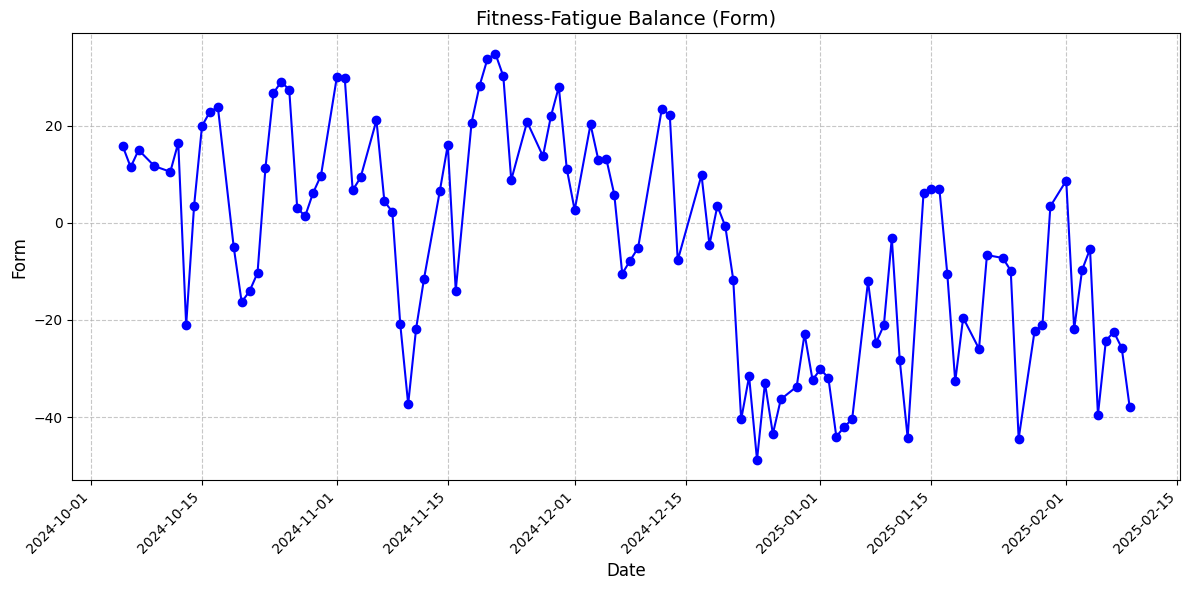

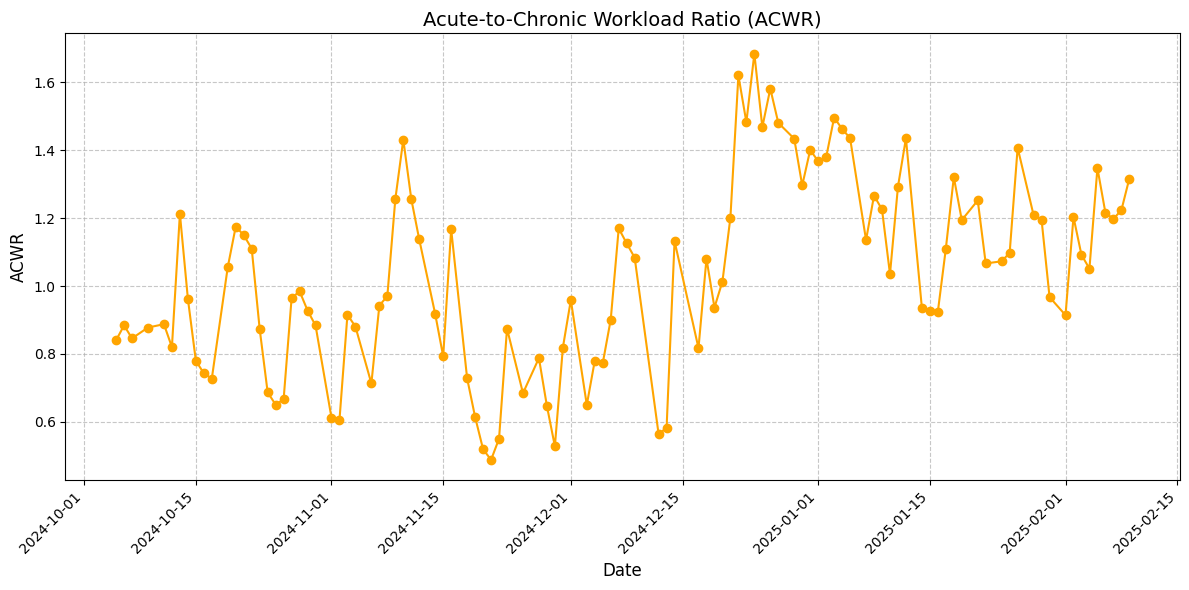

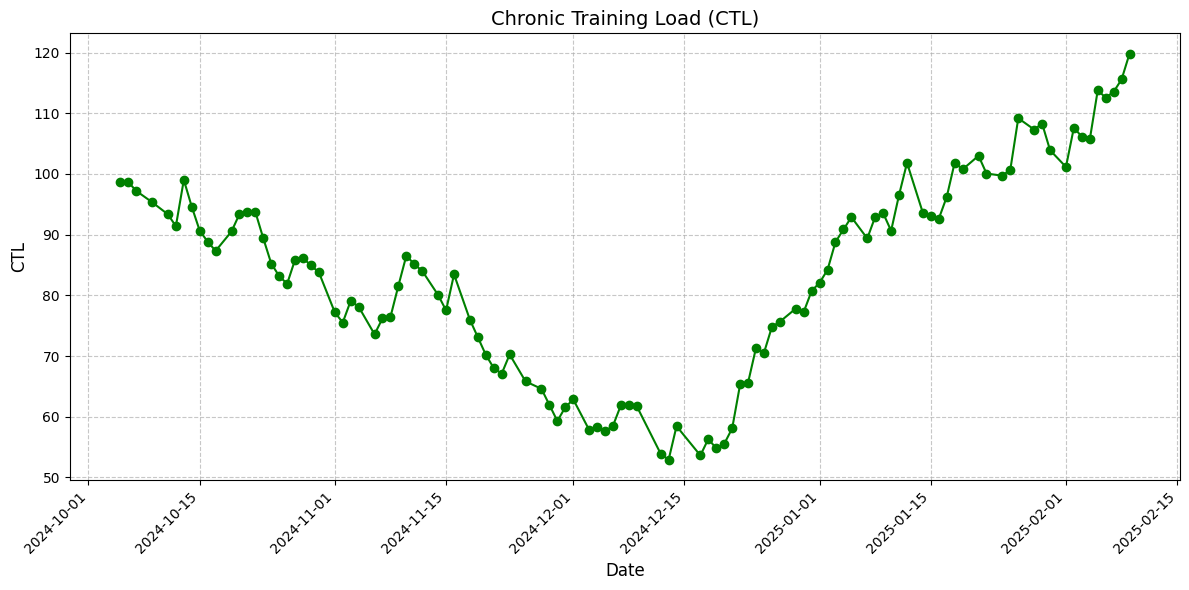

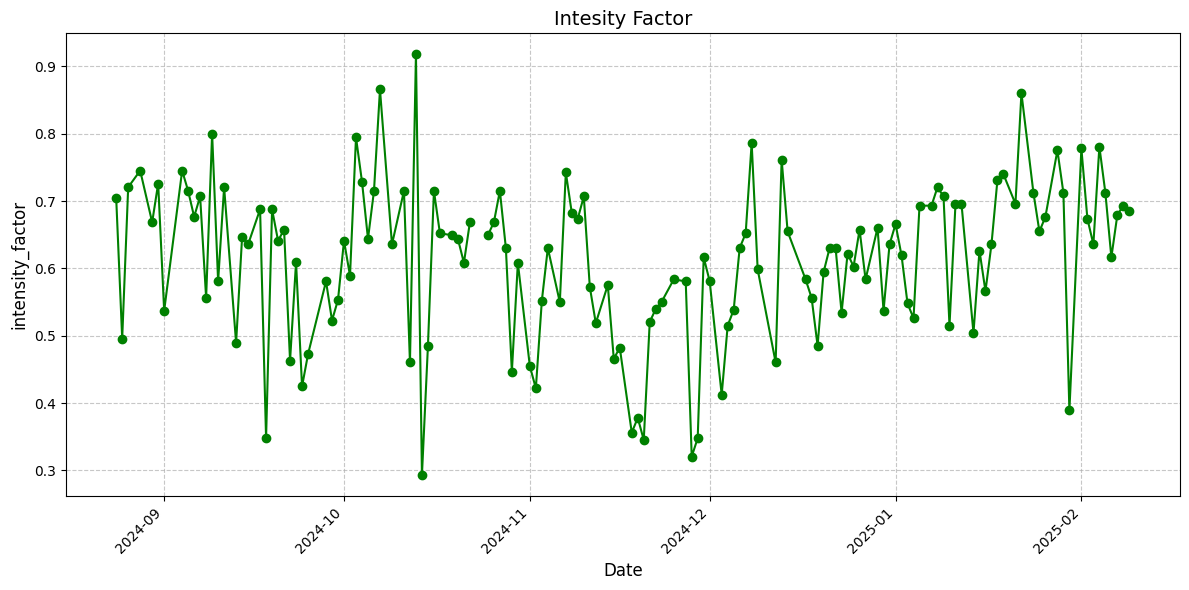

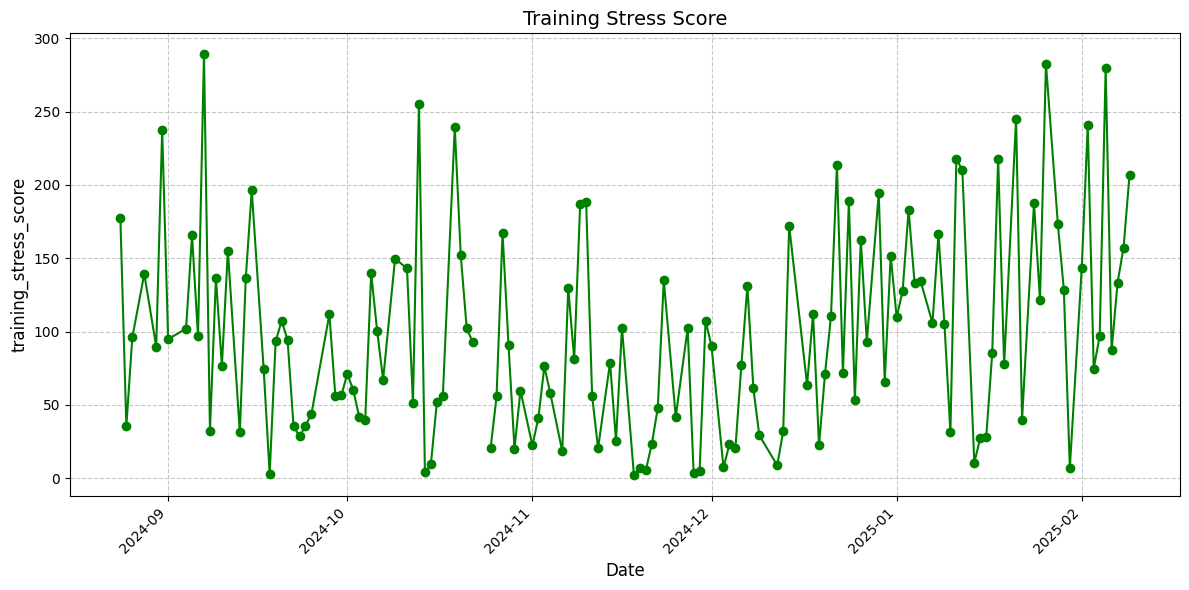

In [24]:
#@title [Get] Plots for Gemini API call
form_plot_path, acwr_plot_path, ctl_plot_path, intensity_factor_plot_path, training_stress_score_plot_path = plot_metrics(cycling_data_with_stress)

In [25]:
#@title Generate and Count tokens in the initial prompt

last_activity, seven_day_avg, recent_avg, older_avg, all_time_avg, activity_counts, totals, cycling_data_df = prepare_performance_data(cycling_data_with_stress)
initial_prompt = generate_enhanced_prompt(last_activity, seven_day_avg, recent_avg, older_avg, all_time_avg, activity_counts, totals, cycling_data_with_stress)
initial_prompt_tokens = model.count_tokens(initial_prompt)
print(f"Initial prompt token count: {initial_prompt_tokens.total_tokens}")

  and should_run_async(code)










Initial prompt token count: 9781


## [Gemini] Single chat session

In [26]:
#@title Send message with uploaded files in chat session
# last_activity, seven_day_avg, recent_avg, older_avg, all_time_avg, activity_counts, totals, cycling_data_df = prepare_performance_data(cycling_data_with_stress)
# prompt = generate_enhanced_prompt(last_activity, seven_day_avg, recent_avg, older_avg, all_time_avg, activity_counts, totals, cycling_data_with_stress)
# chat_session = model.start_chat(
#   history=[
#       {
#           "role": "user",
#           "parts": [prompt],
#       },
#       {
#           "role": "user",
#           "parts": [files[0], files[1], files[2]],  # Attach images
#       },
#   ]
# )

# response = chat_session.send_message("The conversaion will now switch to ITALIAN language. Translate your initial response and following iteration untill further user ask.")
# print(response.text)

  and should_run_async(code)



## [Gemini] Multi chat session

In [27]:
# [Gemini] Upload Plots to Gemini - files path
plots_for_gemini = [
  upload_to_gemini(form_plot_path, mime_type="image/png"),
  upload_to_gemini(acwr_plot_path, mime_type="image/png"),
  upload_to_gemini(ctl_plot_path, mime_type="image/png"),
  upload_to_gemini(intensity_factor_plot_path, mime_type="image/png"),
  upload_to_gemini(training_stress_score_plot_path, mime_type="image/png"),
]

Uploaded file 'form_plot.png' as: https://generativelanguage.googleapis.com/v1beta/files/y246uclm851f


  for _, mapping in list(self._mappings_to_server.items()):



Uploaded file 'acwr_plot.png' as: https://generativelanguage.googleapis.com/v1beta/files/tl5e00kto6r5
Uploaded file 'ctl_plot.png' as: https://generativelanguage.googleapis.com/v1beta/files/uszuzkzxnvdq
Uploaded file 'intensity_factor_plot.png' as: https://generativelanguage.googleapis.com/v1beta/files/63xadshlsyik
Uploaded file 'training_stress_score_plot.png' as: https://generativelanguage.googleapis.com/v1beta/files/nx2yl7srgoob


In [28]:
#@title Gemini Chat


# Start a chat session using the existing 'model'
chat = model.start_chat(  history=[
      {
          "role": "user",
          "parts": [initial_prompt],
      },
      {
          "role": "user",
          "parts": plots_for_gemini,  # Use the uploaded plot references here
      },
  ]
)



response = chat.send_message("The conversaion will now switch to ITALIAN language. Translate your initial response and following iteration untill further user ask. Ensure to tell if you got the charts and what the data are telling.")

# Display the initial response
display(Markdown(response.text))

# --- Continue the Conversation ---
total_tokens_used = model.count_tokens(initial_prompt).total_tokens
while True:
    user_input = input("Enter your message (or type 'quit' to exit): ")
    if user_input.lower() == 'quit':
        break

    # Count tokens in user input
    user_input_tokens = model.count_tokens(user_input)
    print(f"User input token count: {user_input_tokens.total_tokens}")
    total_tokens_used += user_input_tokens.total_tokens

    response = chat.send_message(user_input)
    display(Markdown(response.text))

    # Extract token count from the response
    try:
        for candidate in response.candidates:
            for part in candidate.content.parts:
                if part.text:
                    response_tokens = model.count_tokens(part.text)
                    print(f"Response token count (part): {response_tokens.total_tokens}")
                    total_tokens_used += response_tokens.total_tokens
    except (AttributeError, IndexError) as e:
        print(f"Could not extract token count from response: {e}")

    print(f"Total tokens used so far: {total_tokens_used}")

Okay, Manuele, ho analizzato i tuoi dati. Ho ricevuto anche i grafici, grazie! Mi danno un quadro ancora più chiaro della tua condizione.

Ecco un riassunto della tua situazione attuale:

**Ultimo allenamento (2025-02-09):**

*   Un'uscita di 4.4 ore per 119.9 km con 1942m di dislivello, potenza normalizzata di 250W e una frequenza cardiaca media di 114 bpm. TSS di 207.0 e IF di 0.68. Ottima uscita lunga in Z2 e Z3.

**Riepilogo degli ultimi periodi:**

| Periodo        | Distanza (km) | Durata (ore) | Dislivello (m) | TSS     |
| -------------- | ------------- | ------------ | ------------- | ------- |
| Ultimi 7 giorni | 598.3         | 21.8         | 9169.1        | 1036.9  |
| Ultimi 30 giorni| 2111.5        | 74.8         | 32231.0       | 3629.2  |
| Precedenti 30 gg| 2119.7        | 75.3         | 25903.0       | 2876.6  |

**Stress e Forma:**

*   **CTL:** 119.8 (Alto, in rapido aumento)
*   **ACWR:** 1.32 (Rischio di sottoallenamento, in aumento)
*   **Form (TSB):** -37.9 (Alta fatica)
*   **TSS settimanale:** 1036.9 (Picco di allenamento)

**Distribuzione Zone di Potenza (Ultimi 7 giorni):**

*   Z1: 35.5%
*   Z2: 30.7%
*   Z3: 19.3%
*   Z4: 10.2%

**Valutazione Generale:**

Manuele, sei in un periodo di carico molto intenso, come dimostra l'alto TSS settimanale e il CTL elevato. L'ACWR a 1.32 indica che stai gestendo bene il carico, ma sei al limite. La Form a -37.9 suggerisce che sei affaticato, il che è normale in questa fase di allenamento invernale.

Considerando che siamo in fase di preparazione invernale, l'obiettivo è aumentare gradualmente il carico di lavoro. Stai facendo un ottimo lavoro, ma dobbiamo fare attenzione a non esagerare.

**Raccomandazioni:**

1.  **Recupero:** Considera un giorno di riposo attivo (Z1) o un'uscita molto leggera per favorire il recupero.
2.  **Prossimi allenamenti:** Continua con uscite lunghe in Z2 e Z3, ma riduci leggermente l'intensità per i prossimi 2-3 giorni.
3.  **Monitoraggio:** Presta attenzione ai segnali del tuo corpo. Se ti senti eccessivamente stanco, prenditi un giorno di riposo completo.

**Prossimi passi:**

*   Cosa ne pensi di questa valutazione?
*   Hai qualche gara in programma che dobbiamo considerare?
*   Preferisci allenarti indoor o outdoor?
*   Hai qualche domanda specifica su cui vuoi che mi concentri?
*   Come ti senti fisicamente?

Dimmi cosa ne pensi, Manuele, e possiamo affinare il piano!


Enter your message (or type 'quit' to exit): quit


- !!!! Integrare altri dati come fitbit
- https://scikit-sports.readthedocs.io/en/latest/index.html >> investigare cosa si puo fare